# MMP Policy Evaluation: Exploring Enforcement Types

### What other types of enforcements are our treatment and comparison facilities receiving? What does the broader enforcement landscape look like?

<i> Maggie Hilderbran

##### 0. Set-up.

In [1]:
import sys
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yaml
from pathlib import Path
from IPython.display import clear_output

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [2]:
# import & use utility functions sitting in 'main.py'
sys.path.append('../../../ca_mmp')
from policy_eval import main
from policy_eval import scrape_facility_reports as sr

##### 1. Reading in and preprocessing data.

In [3]:
print('Reading in configuration and data files.')
clear_output(wait=True)

# read in configuration file
print('Reading in configuration file.')
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['CIWQS_data_path'])
clear_output(wait=True)

# read in data
print('Reading violations file.')
violations = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
clear_output(wait=True)
print('Reading enforcements file.')
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1', 'TERMINATION DATE.1'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID', 'NPDES # CA#': 'NPDES# CA#'}, inplace=True)
clear_output(wait=True)
print('Reading enforcements-violations crosswalk file.')
enf_viol_links = pd.read_excel(data_path / 'Copy-of-RegMeasViolations.xlsx', dtype={'Violation ID': object})
clear_output(wait=True)
print('Reading DMR values file.')
'''dmr_values = pd.read_csv(data_path / 'CA_dmrs_20221123.csv',
                         parse_dates=['monitoring_period_end_date'],
                         date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
clear_output(wait=True)'''

Reading DMR values file.


"dmr_values = pd.read_csv(data_path / 'CA_dmrs_20221123.csv',\n                         parse_dates=['monitoring_period_end_date'],\n                         date_parser=lambda x: pd.to_datetime(x, errors='coerce'))\nclear_output(wait=True)"

In [4]:
print('Cleaning enforcements data.')
enforcements_mmp = main.clean_enforcements(enforcements, mmp_only=True)
clear_output(wait=True)

Cleaning enforcements data.


In [5]:
print('Cleaning violations data.')
# filter violations table to MMP non-exempt, effluent violations
violations_mmp = main.clean_violations(violations, mmp_only=True, effluent_only=True)
clear_output(wait=True)

Cleaning violations data.


In [6]:
# subset to only valid MMP-related EPLs and estimate EPL issuance dates (NB: 'valid' = status is not 'Withdrawn' or 'Draft')
print('Identifying valid, MMP-related EPLs and estimating issuance dates.\n')
enforcements_mmp_epl = main.get_epls(enforcements_mmp, valid_only=False)  # estimating using 'EFFECTIVE DATE.1' as a backup
clear_output(wait=True)

Identifying valid, MMP-related EPLs and estimating issuance dates.



In [7]:
# link enforcements and violations data (result: table of all violations that are linked to an MMP EPL enforcement action)
print('Linking valid, MMP-related EPLs to MMP-eligible, effluent violations.')
violations_mmp_epl = enf_viol_links.merge(enforcements_mmp_epl, how='right', left_on='Reg Measure ID',
                                          right_on='ENFORCEMENT ID (EID)')
violations_mmp_epl.drop('Reg Measure ID', axis=1, inplace=True)
violations_mmp_epl.rename(columns={'Violation ID': 'VIOLATION ID (VID)'}, inplace=True)

violations_mmp_epl_merged = violations_mmp_epl.merge(violations_mmp, on=['VIOLATION ID (VID)'], how='inner')
clear_output(wait=True)

Linking valid, MMP-related EPLs to MMP-eligible, effluent violations.


##### 2. Defining treatment & comparison groups.

In [8]:
# creating facilities table
facilities = pd.DataFrame()
facilities['FACILITY_ID'] = violations_mmp['FACILITY_ID'].unique()

**Question #1: Did a facility receive an EPL in the '08-09 enforcement push?**

In [9]:
print('Identifying facilities that did and did NOT receive EPLs in \'08-09 push.')
facilities_epl_treat = enforcements_mmp_epl[
                                            (enforcements_mmp_epl['estimated_epl_date'] >= pd.to_datetime(main.TREATMENT_START_DATE)) &
                                            (enforcements_mmp_epl['estimated_epl_date'] <= pd.to_datetime(main.TREATMENT_END_DATE)) &
                                            (enforcements_mmp_epl['STATUS.1'].apply(lambda x: x not in ['Withdrawn', 'Draft']))
                                            ]
facilities_epl_treat = facilities_epl_treat['FACILITY_ID'].unique()

# identify facilities which received EPLs in 08-09 which were later withdrawn
facilities_epl_withdrawn = enforcements_mmp_epl[
                                            (enforcements_mmp_epl['estimated_epl_date'] >= pd.to_datetime(main.TREATMENT_START_DATE)) &
                                            (enforcements_mmp_epl['estimated_epl_date'] <= pd.to_datetime(main.TREATMENT_END_DATE)) &
                                            (enforcements_mmp_epl['STATUS.1']=='Withdrawn')
                                            ]
facilities_epl_withdrawn = facilities_epl_withdrawn['FACILITY_ID'].unique()

facilities['epl_treat_flag'] = facilities['FACILITY_ID'].isin(facilities_epl_treat)
clear_output(wait=True)

Identifying facilities that did and did NOT receive EPLs in '08-09 push.


**Question #2: Was MMP consistently enforced for a facility prior to the '08-09 push?**

Here, we consider two different interpretations of 'prior to the '08-09 push': a) prior to treatment and b) during pretreatment.

We calculate the enforcement rate, borrowing Ryan's method (see `sample_identification.ipynb`).
Due to the difficulty of accounting for instances where a single violation is linked to multiple enforcement actions, here we define enforcement rate as the sum of the number of  MMP violations linked to pre-push enforcements(`enforcements_mmp_prior_violcount`, `enforcements_mmp_pretreat_violcount`) divided by the number of pre-push MMP violations (`violations_mmp_prior_count`, `violations_mmp_pretreat_count`). Thus, the enforcement rate can exceed 1 when a violation is enforced multiple times.

In [10]:
print('Identifying facilities with and without consistent enforcement of MMP program a) prior to treatment and b) during pretreatment.')
print('     (\'Consistent\' enforcement = enforcement rate of',main.HIGH_ENFORCEMENT_RATE_THRESHOLD,'or greater.)')


# get count of MMP violations linked to prior enforcements for each facility
enforcements_mmp_prior_violcounts = enforcements_mmp[enforcements_mmp['EFFECTIVE DATE.1'] < pd.to_datetime(main.TREATMENT_START_DATE)
                                                     ].groupby('FACILITY_ID', as_index=False).sum()[['FACILITY_ID',
                                                                                                        'TOTAL MMP VIOLATIONS #']]
enforcements_mmp_prior_violcounts.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcements_mmp_prior_violcount'},
                                         inplace=True)

# get count of ALL MMP violations prior to treatment
facilities = facilities.merge(enforcements_mmp_prior_violcounts, how='left', on='FACILITY_ID')

violations_mmp_prior = violations_mmp[violations_mmp['OCCURRED ON'] < pd.to_datetime(main.TREATMENT_START_DATE)
                                      ].groupby('FACILITY_ID', as_index=False).nunique()[['FACILITY_ID',
                                                                                             'VIOLATION ID (VID)']]
violations_mmp_prior.rename(columns={'VIOLATION ID (VID)': 'violations_mmp_prior_count'},
                            inplace=True)
facilities = facilities.merge(violations_mmp_prior, how='left', on='FACILITY_ID')

# calculate enforcement rate during period prior to treatment
facilities['enforcement_prior_rate'] = facilities['enforcements_mmp_prior_violcount'] / \
                                       facilities['violations_mmp_prior_count']


# get count of MMP violations linked to pretreatment enforcements for each facility
enforcements_mmp_pretreat_violcounts = enforcements_mmp[(enforcements_mmp['EFFECTIVE DATE.1'] < pd.to_datetime(main.TREATMENT_START_DATE)) &
                                                        (enforcements_mmp['EFFECTIVE DATE.1'] >= pd.to_datetime(main.PRETREATMENT_START_DATE))
                                                        ].groupby('FACILITY_ID', as_index=False).sum()[['FACILITY_ID',
                                                                                                        'TOTAL MMP VIOLATIONS #']]
enforcements_mmp_pretreat_violcounts.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcements_mmp_pretreat_violcount'},
                                            inplace=True)

# get count of ALL MMP violations during pretreatment period
facilities = facilities.merge(enforcements_mmp_pretreat_violcounts, how='left', on='FACILITY_ID')

violations_mmp_pretreat = violations_mmp[(violations_mmp['OCCURRED ON'] < pd.to_datetime(main.TREATMENT_START_DATE)) &
                                         (violations_mmp['OCCURRED ON'] >= pd.to_datetime(main.PRETREATMENT_START_DATE))
                                         ].groupby('FACILITY_ID', as_index=False).nunique()[['FACILITY_ID',
                                                                                             'VIOLATION ID (VID)']]
violations_mmp_pretreat.rename(columns={'VIOLATION ID (VID)': 'violations_mmp_pretreat_count'},
                               inplace=True)
facilities = facilities.merge(violations_mmp_pretreat, how='left', on='FACILITY_ID')

# calculate enforcement rate during pretreatment period
facilities['enforcement_pretreat_rate'] = facilities['enforcements_mmp_pretreat_violcount'] / \
                                          facilities['violations_mmp_pretreat_count']


# identify facilities with 'consistent' enforcement
facilities['enforcement_prior_flag'] = facilities['enforcement_prior_rate'] >= main.HIGH_ENFORCEMENT_RATE_THRESHOLD
facilities['enforcement_pretreat_flag'] = facilities['enforcement_pretreat_rate'] >= main.HIGH_ENFORCEMENT_RATE_THRESHOLD


# replace NaN with 0
facilities.fillna(0, inplace=True)
facilities.head()

Identifying facilities with and without consistent enforcement of MMP program a) prior to treatment and b) during pretreatment.
     ('Consistent' enforcement = enforcement rate of 0.75 or greater.)


,FACILITY_ID,epl_treat_flag,enforcements_mmp_prior_violcount,violations_mmp_prior_count,enforcement_prior_rate,enforcements_mmp_pretreat_violcount,violations_mmp_pretreat_count,enforcement_pretreat_rate,enforcement_prior_flag,enforcement_pretreat_flag
0,259171,False,278.0,180.0,1.544444,0.0,15.0,0.0,True,False
1,261701,False,0.0,8.0,0.000000,0.0,4.0,0.0,False,False
2,233276,False,0.0,2.0,0.000000,0.0,0.0,0.0,False,False
3,236817,False,0.0,3.0,0.000000,0.0,2.0,0.0,False,False
4,248886,False,19.0,23.0,0.826087,0.0,0.0,0.0,True,False


In [11]:
# treatment facilities need to have a) received an EPL during our treatment period
# and b) had a low MMP enforcement rate prior to the treatment period
treatment_facilities = list(facilities[(facilities['epl_treat_flag']) &
                                  (facilities['enforcement_prior_rate'] <= main.LOW_ENFORCEMENT_RATE_THRESHOLD)]['FACILITY_ID'])
# comparison facilities need to have a) NOT received an EPL during the treatment period
# and b) had a high MMP enforcement rate prior to the treatment period
comparison_facilities = list(facilities[~(facilities['epl_treat_flag']) &
                                  (facilities['enforcement_prior_flag']) &
                                  (facilities['FACILITY_ID'].apply(lambda x: x not in facilities_epl_withdrawn))]['FACILITY_ID'])

# set aside treatment and comparison violations
treatment_violations = violations_mmp[violations_mmp['FACILITY_ID'].apply(lambda x: x in treatment_facilities)]
comparison_violations = violations_mmp[violations_mmp['FACILITY_ID'].apply(lambda x: x in comparison_facilities)]

**Question #3: Did a facility have an active NPDES permit throughout our analysis period?**

In [12]:
# get Facility At-A-Glance report for each facility (via 'place_ids', which are our 'FACILITY_ID' values)
# OPTION 1: scrape from web
place_ids = [*treatment_facilities, *comparison_facilities]
print(f'Scraping Facility At-A-Glance data for {len(place_ids)} facilities.')
facility_reports = sr.scrape_facility_reports(place_ids, verbose=True)
facility_reports.to_csv('facility_reports.csv')
# OPTION 2: read CSV of already-scraped reports
'''facility_reports = pd.read_csv('facility_reports.csv',
                               dtype={'FACILITY ID': object},
                               parse_dates=['Effective Date', 'Expiration Date'],
                               date_parser=lambda x: pd.to_datetime(x, errors='coerce'))'''
facility_reports.head()

,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?,FACILITY_ID
0,134044,NPDES Permit,2,NPDINDSML,R2-2005-0010,2 019112001,2005-04-20,2010-04-20,Historical,Y,241493
0,143090,NPDES Permit,2,NPDINDSML,97-025,2 019112001,1997-02-19,2005-04-20,Historical,N,241493
0,141852,NPDES Permit,2,NPDESWW,90-108,2 019112001,1990-08-15,1995-08-15,Historical,N,241493
0,146033,NPDES Permit,2,NPDESWW,84-08503,2 019112001,1984-12-18,1989-12-18,Historical,N,241493
0,145235,NPDES Permit,2,NPDESWW,79-041,2 019112001,1979-04-17,1984-04-17,Historical,N,241493


First, scrape historical permit data from CIWQS for our treatment and comparison groups.

In [13]:
treatment_fac_reports = sr.scrape_facility_reports(treatment_facilities)
comparison_fac_reports = sr.scrape_facility_reports(comparison_facilities)

In [14]:
# get estimated facility entrance/exit dates into/from population
treatment_violations = main.get_facility_entrance_exit(facility_reports[facility_reports['FACILITY_ID'].apply(lambda x: x in treatment_facilities)], treatment_violations)
comparison_violations = main.get_facility_entrance_exit(facility_reports[facility_reports['FACILITY_ID'].apply(lambda x: x in comparison_facilities)], comparison_violations)

For stable group composition, we need to condition on having an active NPDES permit during the analysis period. Here, we set it to 2004-2012.

In [15]:
treatment_violations = treatment_violations[
                                # Enter the population by 2004
                                (treatment_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(treatment_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]
comparison_violations = comparison_violations[
                                # Enter the population by 2004
                                (comparison_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(comparison_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]

**Our final sample:**

In [16]:
# Redefine sets of treatment and control facilities
treatment_facilities = list(treatment_violations['FACILITY_ID'].unique())
comparison_facilities = list(comparison_violations['FACILITY_ID'].unique())
print(f'Facilities in treatment group: {len(treatment_facilities)}.')
print(f'Facilities in comparison group: {len(comparison_facilities)}.')

Facilities in treatment group: 43.
Facilities in comparison group: 96.


##### 3. Exploring different types of enforcements across all facilities.

We're specifically interested in Time Schedule Orders (TSOs) and Cease and Desist Orders (CDOs) - two types of enforcement actions (as identified by Erin) where compliance might be 'hiding,' such that we wouldn't catch it by looking at EPLs.

In [17]:
enforcements_npdes = main.clean_enforcements(enforcements, mmp_only=False)

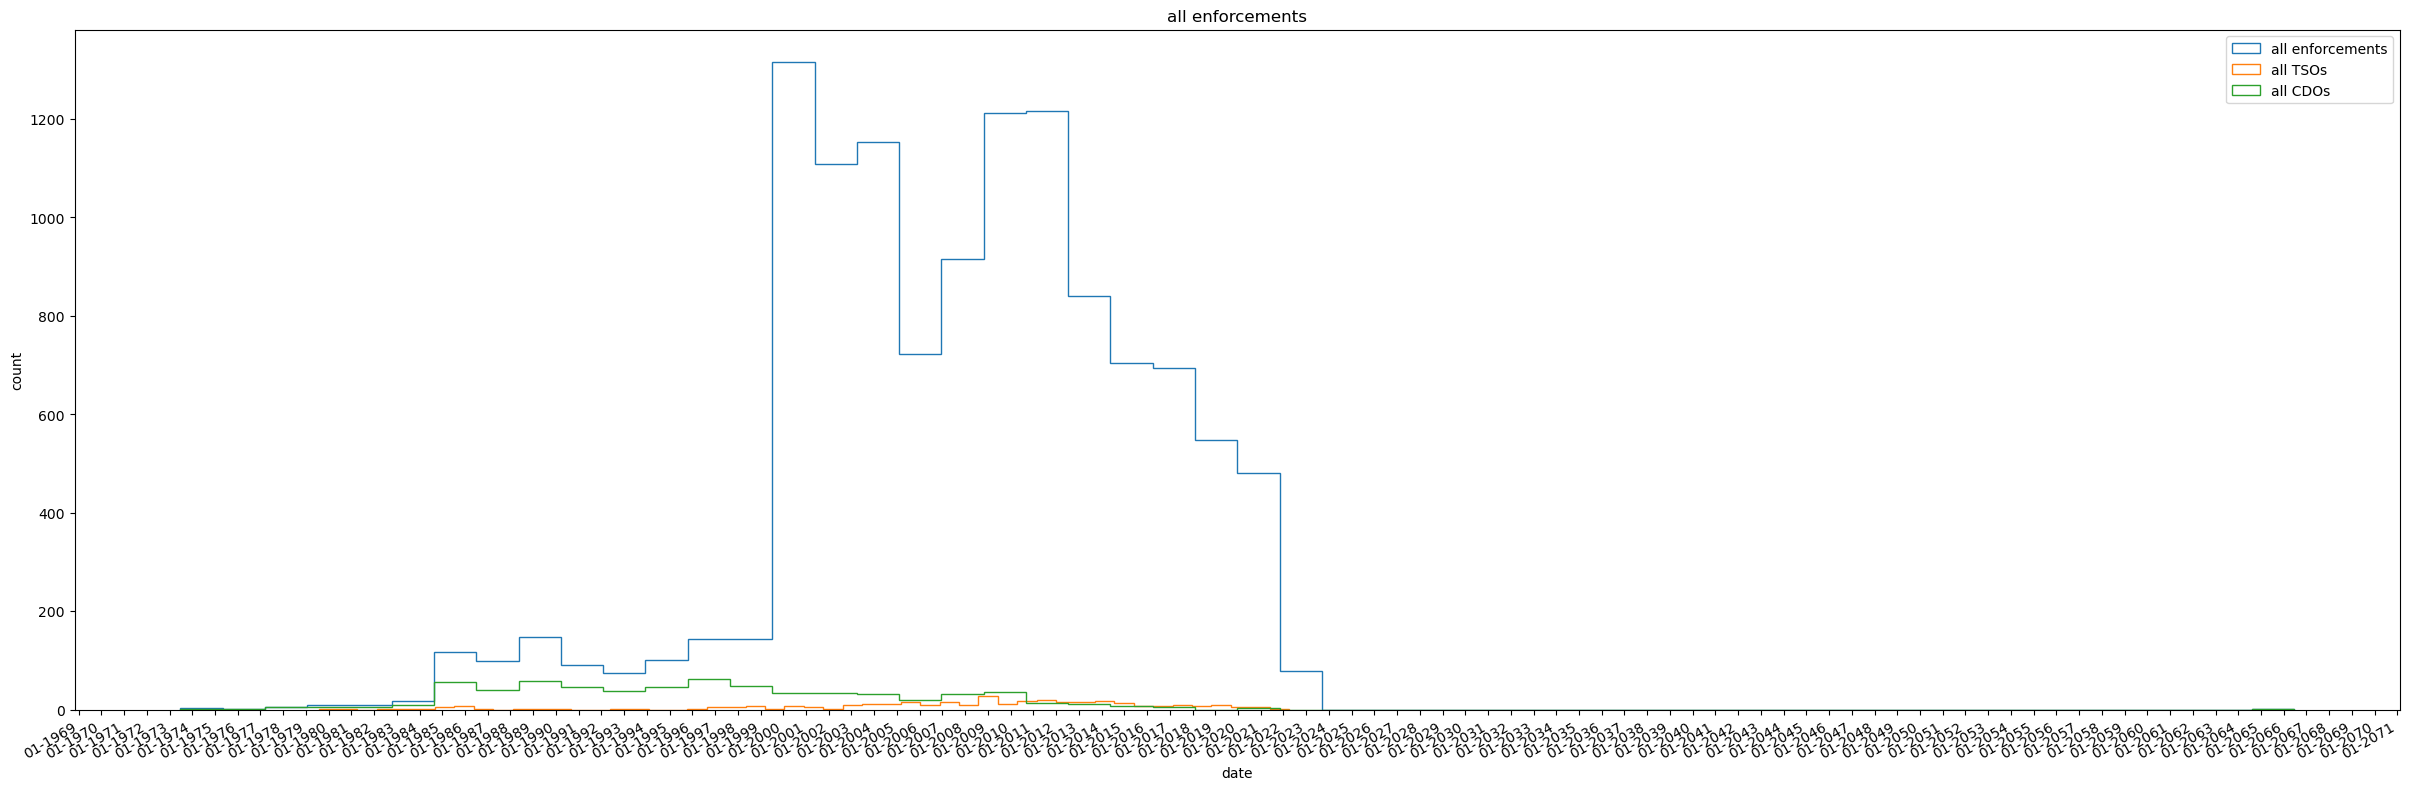

In [18]:
# plot all enforcements over time
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements_npdes['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_npdes[enforcements_npdes['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_npdes[enforcements_npdes['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['all enforcements', 'all TSOs', 'all CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('all enforcements')
ax.set_xlabel('date')
ax.set_ylabel('count');

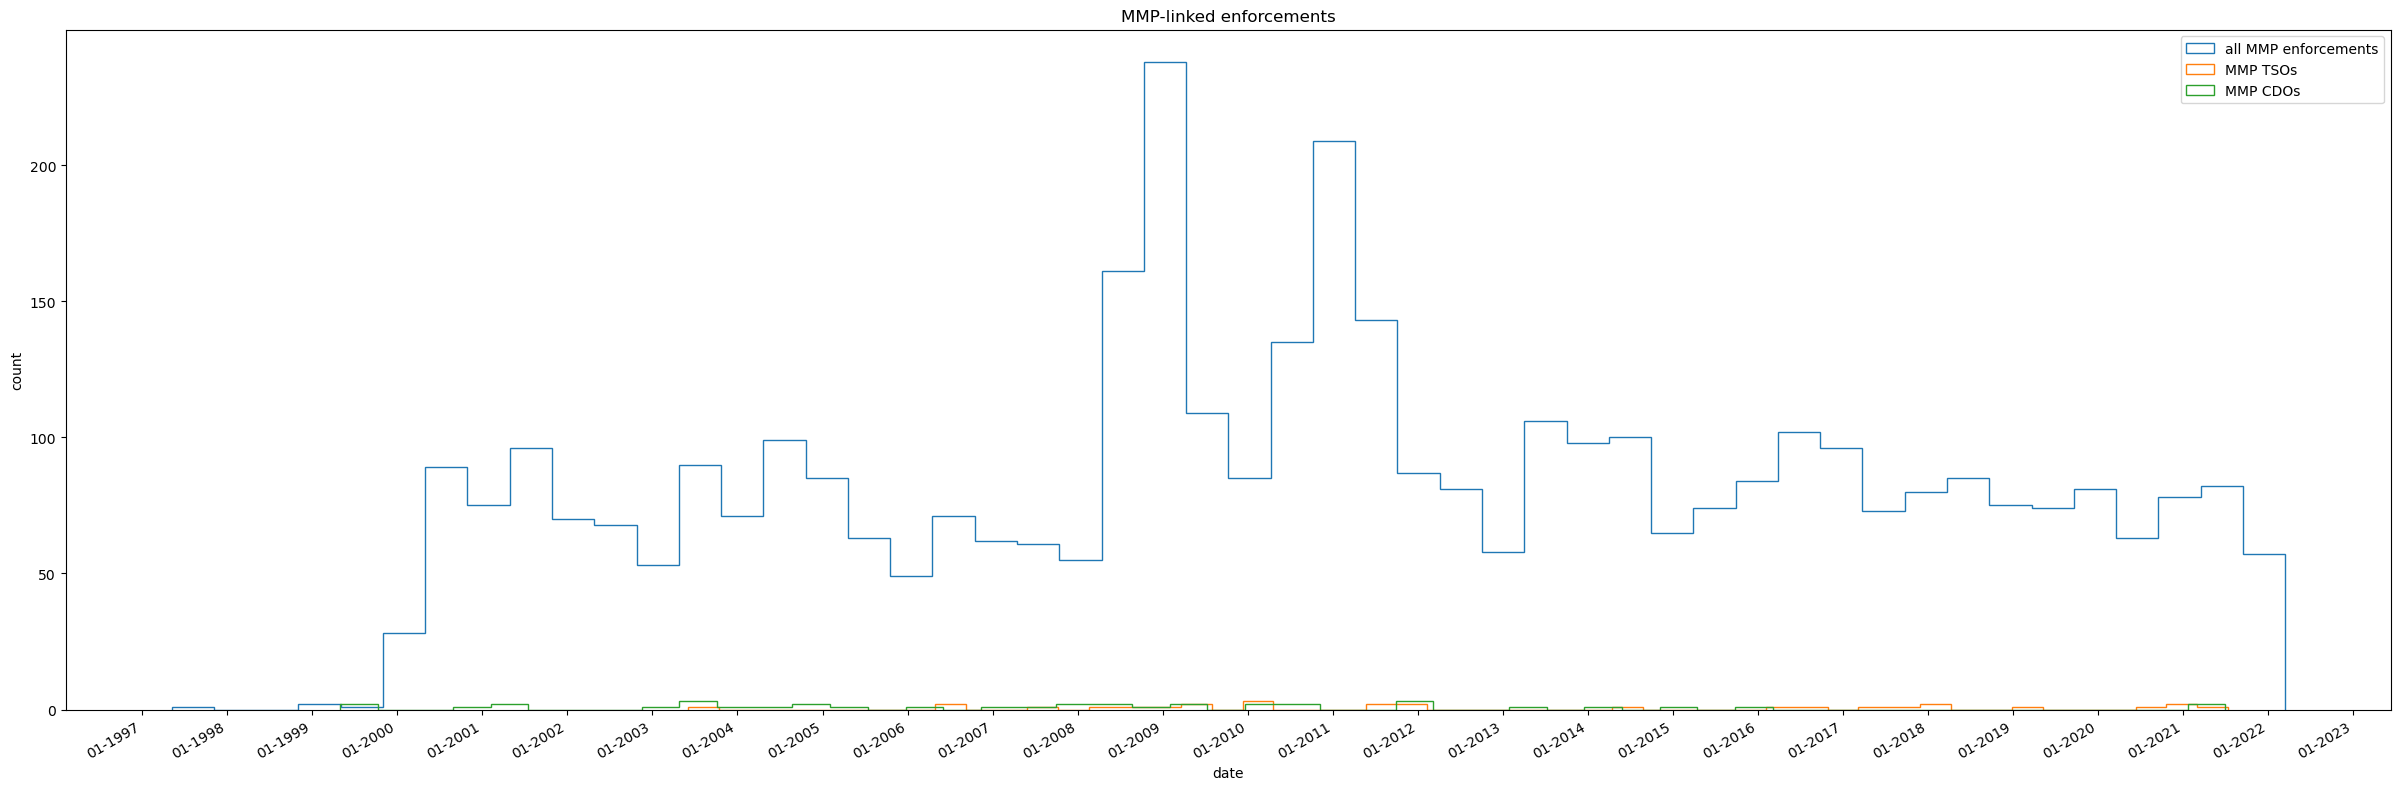

In [19]:
# plot all MMP enforcements over time
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements_mmp['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_mmp[enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_mmp[enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['all MMP enforcements', 'MMP TSOs', 'MMP CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('MMP-linked enforcements')
ax.set_xlabel('date')
ax.set_ylabel('count');

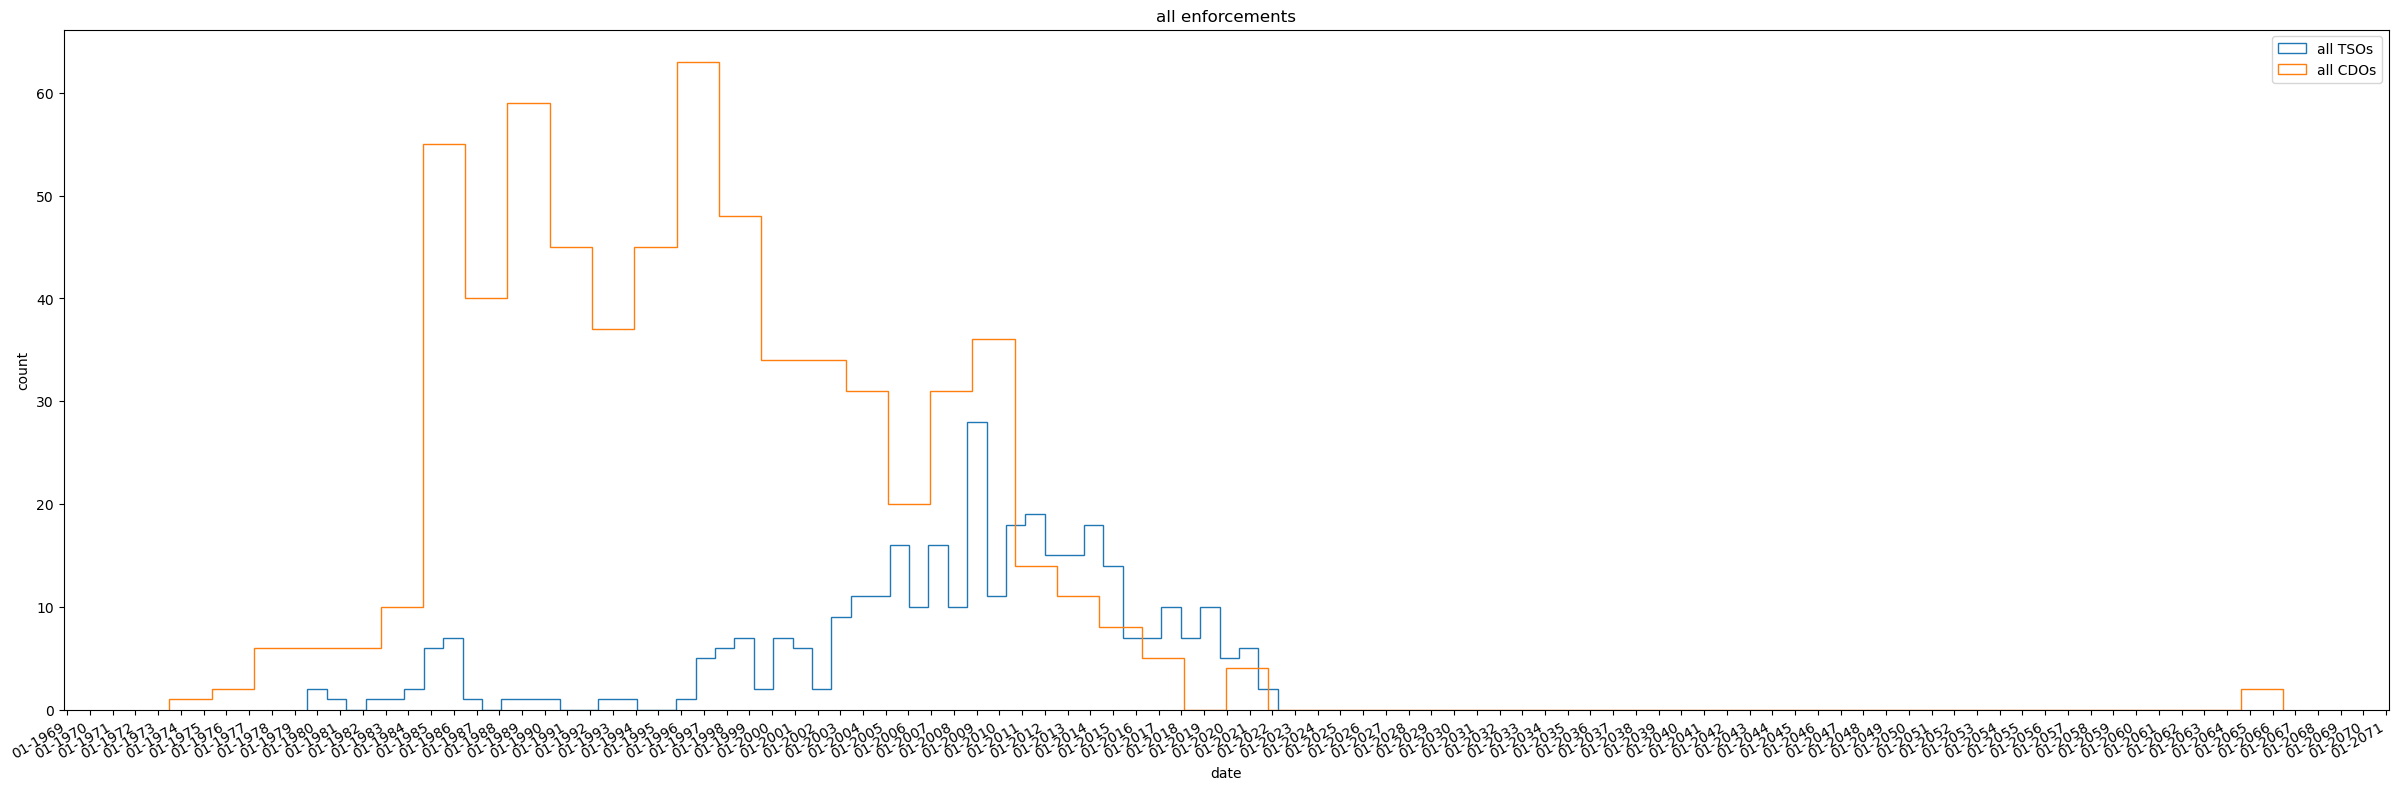

In [20]:
# subset to just TSOs and CDOs
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements_npdes[enforcements_npdes['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_npdes[enforcements_npdes['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['all TSOs', 'all CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('all enforcements')
ax.set_xlabel('date')
ax.set_ylabel('count');

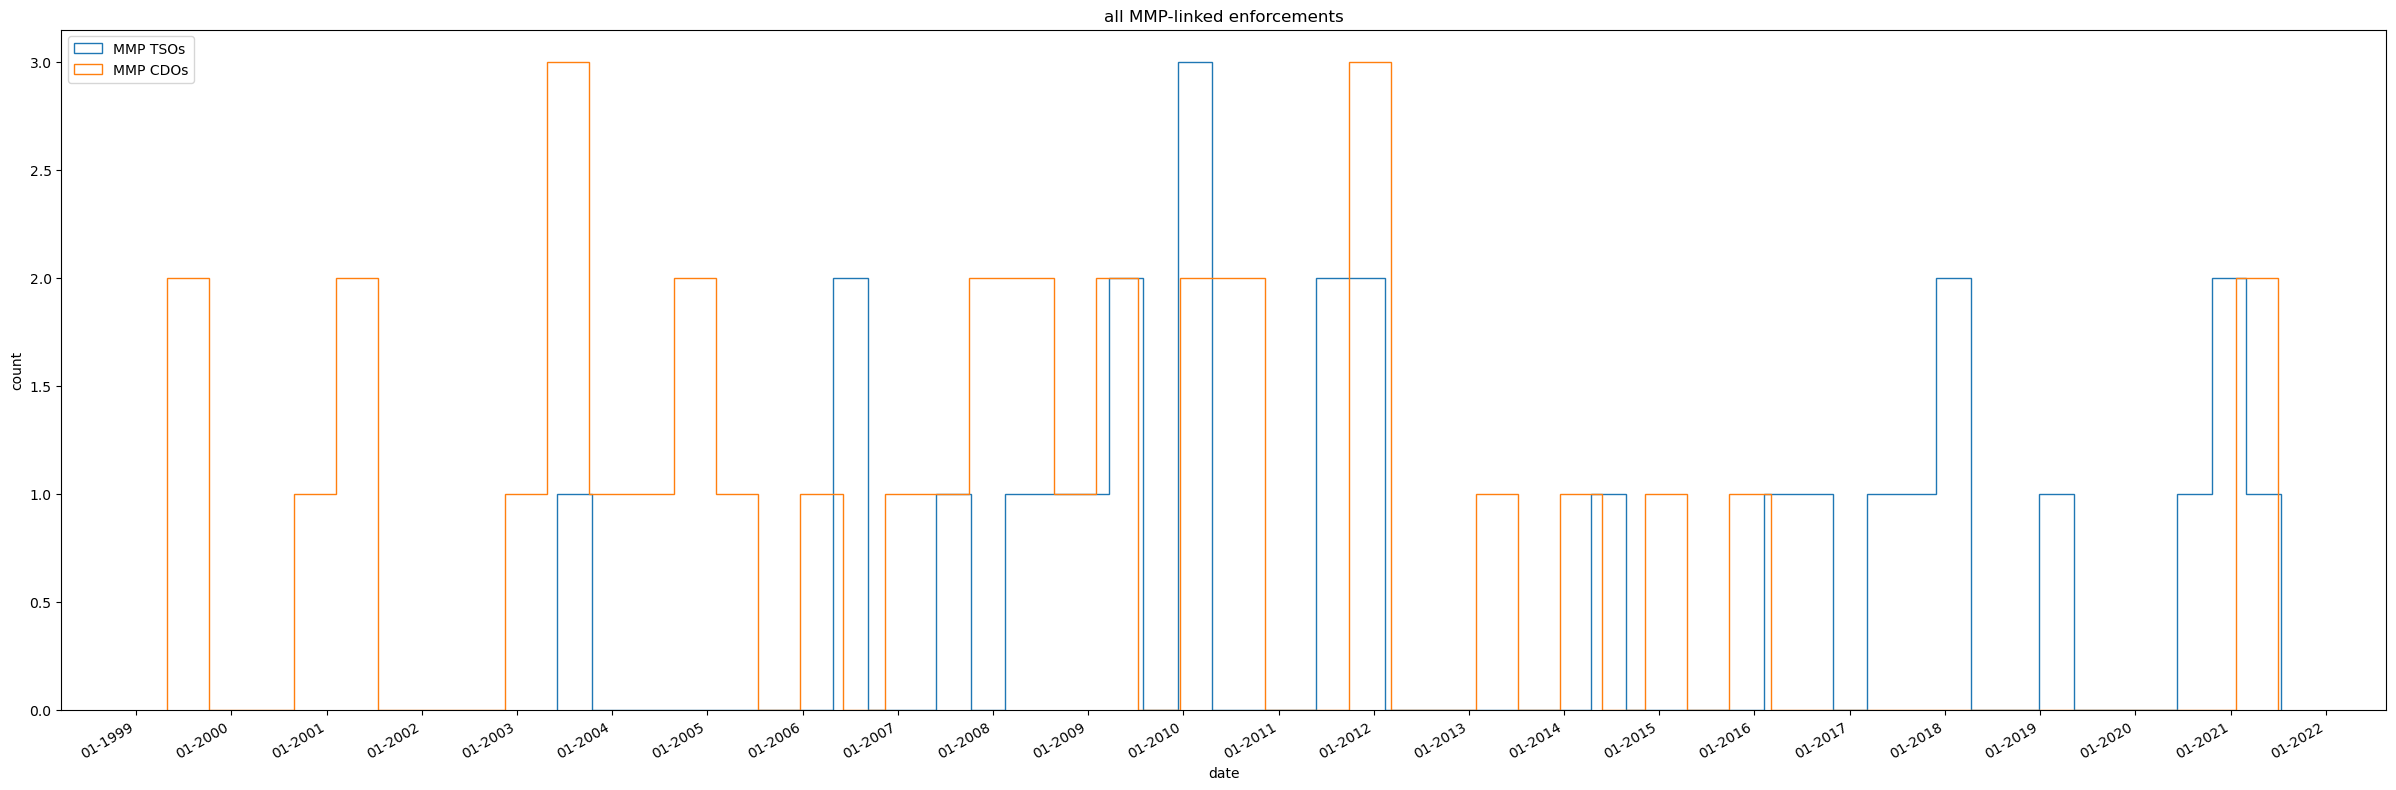

In [21]:
# subset to just TSOs and CDOs for MMPs
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements_mmp[enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(enforcements_mmp[enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['MMP TSOs', 'MMP CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('all MMP-linked enforcements')
ax.set_xlabel('date')
ax.set_ylabel('count');

Let's look beyond TSOs and CDOs - what does the broader enforcement landscape look like over time?

First, let's look at *all* enforcement actions (not just MMP-related).

In [22]:
enforcement_actions = list(enforcements_npdes['ENFORCEMENT ACTION TYPE'].unique())
enforcement_actions

['Admin Civil Liability',
 'Cease and Desist Order',
 'Settlement - Court Order',
 'Oral Communication',
 '13267 Letter',
 'Notice of Violation',
 'Staff Enforcement Letter',
 'Clean-up and Abatement Order',
 'Notice to Comply',
 'Expedited Payment Letter',
 'Time Schedule Order',
 'Formal Refer to Attorney Gen',
 'Referral to USEPA',
 '13383 Letter',
 'Referral to Other Agency',
 'Third Party Action',
 'Referral to Task Force',
 'Waste Discharge Requirements',
 'Referral to District Attorney',
 'Stipulated Penalty']

In [23]:
# define which actions we want to look at separately and which we want to categorize under "other"
primary_actions = ['Admin Civil Liability',
 'Cease and Desist Order',
 'Oral Communication',
 'Notice of Violation',
 'Staff Enforcement Letter',
 'Expedited Payment Letter',
 'Time Schedule Order'
 ]
other_actions = ['Settlement - Court Order',
 '13267 Letter',
 'Clean-up and Abatement Order',
 'Notice to Comply',
 'Formal Refer to Attorney Gen',
 'Referral to USEPA',
 '13383 Letter',
 'Referral to Other Agency',
 'Third Party Action',
 'Referral to Task Force',
 'Waste Discharge Requirements',
 'Referral to District Attorney',
 'Stipulated Penalty'
 ]

In [24]:
enforcements_npdes['effective_year'] = enforcements_npdes['EFFECTIVE DATE.1'].apply(lambda x: x.year)
enforcement_types_by_year_npdes = enforcements_npdes.groupby(['effective_year', 'ENFORCEMENT ACTION TYPE']).size().to_frame('count')
enforcement_types_by_year_npdes.head()

,,count
effective_year,ENFORCEMENT ACTION TYPE,
1973.0,Cease and Desist Order,1
1974.0,Oral Communication,2
1976.0,Cease and Desist Order,2
1977.0,Cease and Desist Order,4
1978.0,Cease and Desist Order,2


In [25]:
enforcement_types_by_year_npdes = enforcement_types_by_year_npdes.pivot_table('count', index='effective_year', columns='ENFORCEMENT ACTION TYPE', fill_value=0)
enforcement_types_by_year_npdes.head()

ENFORCEMENT ACTION TYPE,13267 Letter,13383 Letter,Admin Civil Liability,Cease and Desist Order,Clean-up and Abatement Order,Expedited Payment Letter,Formal Refer to Attorney Gen,Notice of Violation,Notice to Comply,Oral Communication,Referral to District Attorney,Referral to Other Agency,Referral to Task Force,Referral to USEPA,Settlement - Court Order,Staff Enforcement Letter,Stipulated Penalty,Third Party Action,Time Schedule Order,Waste Discharge Requirements
effective_year,,,,,,,,,,,,,,,,,,,,
1973.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1974.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1976.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1977.0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1978.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
enforcement_years_npdes = pd.DataFrame(range(int(np.min(enforcements_npdes['effective_year'])), int(np.max(enforcements_npdes['effective_year']))+1), columns=['effective_year'])

enforcement_types_by_year_npdes = pd.merge(enforcement_types_by_year_npdes, enforcement_years_npdes, how='right', on='effective_year').fillna(0).set_index('effective_year')
enforcement_types_by_year_npdes.head()

,13267 Letter,13383 Letter,Admin Civil Liability,Cease and Desist Order,Clean-up and Abatement Order,Expedited Payment Letter,Formal Refer to Attorney Gen,Notice of Violation,Notice to Comply,Oral Communication,Referral to District Attorney,Referral to Other Agency,Referral to Task Force,Referral to USEPA,Settlement - Court Order,Staff Enforcement Letter,Stipulated Penalty,Third Party Action,Time Schedule Order,Waste Discharge Requirements
effective_year,,,,,,,,,,,,,,,,,,,,
1973.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1976.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1977.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
enforcement_types_by_year_npdes['Other'] = enforcement_types_by_year_npdes[other_actions].sum(axis=1)
enforcement_types_by_year_npdes[primary_actions + ['Other']].head()

,Admin Civil Liability,Cease and Desist Order,Oral Communication,Notice of Violation,Staff Enforcement Letter,Expedited Payment Letter,Time Schedule Order,Other
effective_year,,,,,,,,
1973.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1974.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1976.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1977.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


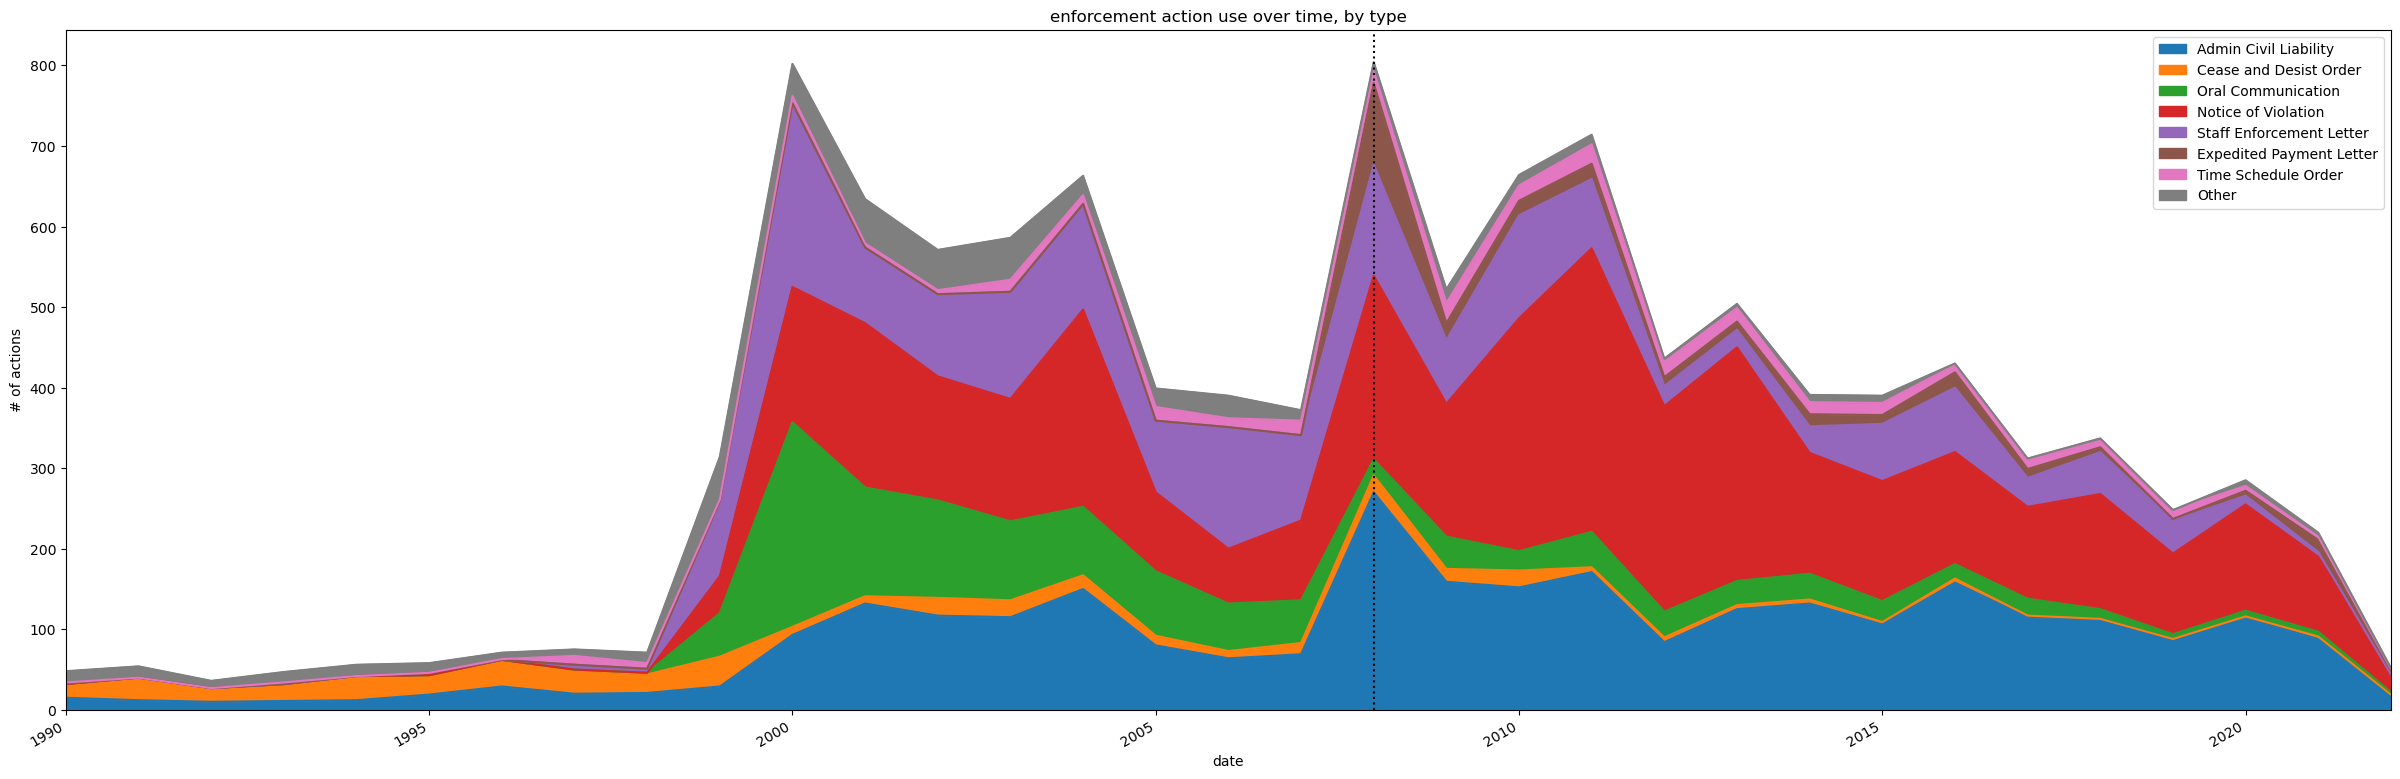

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcement_types_by_year_npdes[primary_actions + ['Other']].plot.area(ax=ax)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('enforcement action use over time, by type')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([1990, 2022]);

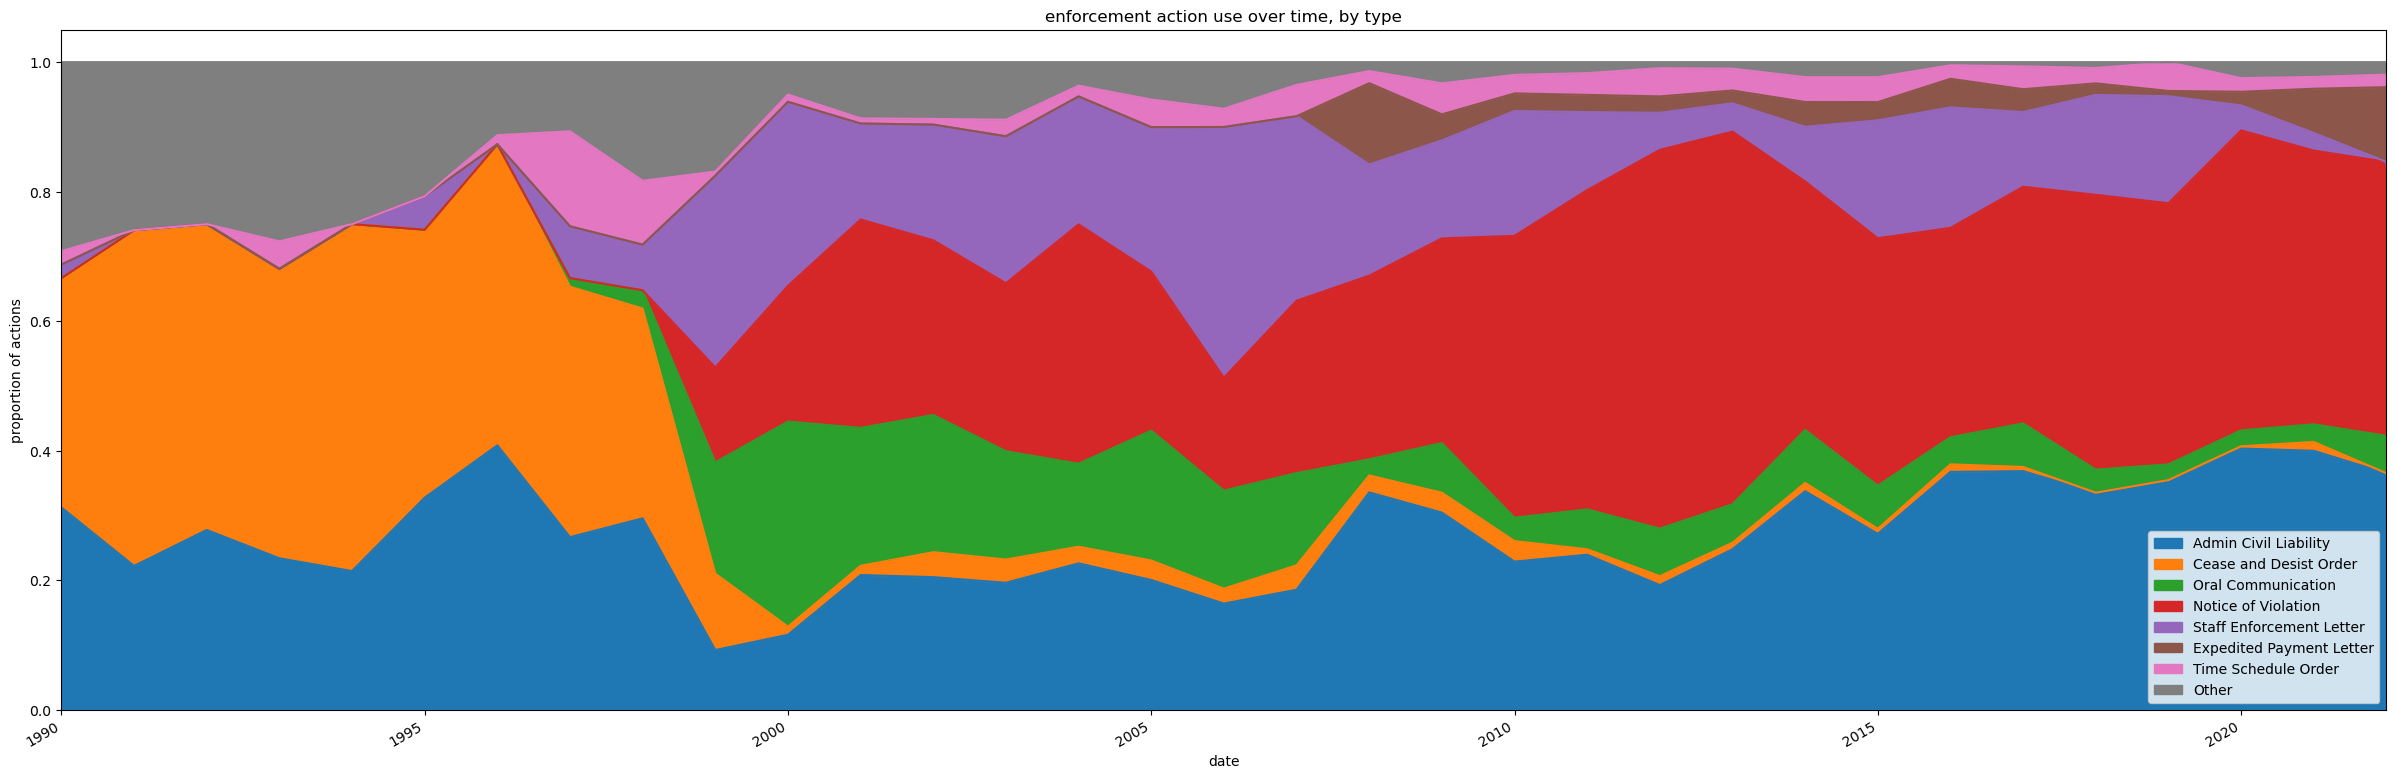

In [29]:
# same plot, but plot proportion of actions rather than absolute number of actions
enforcement_types_by_year_npdes_pct = enforcement_types_by_year_npdes.divide(enforcement_types_by_year_npdes[primary_actions + ['Other']].sum(axis=1), axis=0)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcement_types_by_year_npdes_pct[primary_actions + ['Other']].plot.area(ax=ax)
fig.autofmt_xdate()
ax.set_title('enforcement action use over time, by type')
ax.set_xlabel('date')
ax.set_ylabel('proportion of actions')
ax.set_xlim([1990, 2022]);

First, let's look at *all* enforcement actions (not just MMP-related).

In [30]:
enforcement_actions_mmp = list(enforcements_mmp['ENFORCEMENT ACTION TYPE'].unique())
enforcement_actions_mmp

['Admin Civil Liability',
 'Notice of Violation',
 'Oral Communication',
 'Expedited Payment Letter',
 'Cease and Desist Order',
 'Settlement - Court Order',
 'Staff Enforcement Letter',
 'Formal Refer to Attorney Gen',
 'Time Schedule Order',
 'Notice to Comply',
 'Referral to Other Agency',
 '13267 Letter',
 'Clean-up and Abatement Order',
 'Referral to Task Force',
 'Referral to USEPA']

In [31]:
# define which actions we want to look at separately and which we want to categorize under "other"
primary_actions_mmp = ['Admin Civil Liability',
 'Cease and Desist Order',
 'Oral Communication',
 'Notice of Violation',
 'Staff Enforcement Letter',
 'Expedited Payment Letter',
 'Time Schedule Order'
 ]
other_actions_mmp = ['Settlement - Court Order',
 '13267 Letter',
 'Clean-up and Abatement Order',
 'Notice to Comply',
 'Formal Refer to Attorney Gen',
 'Referral to USEPA',
# '13383 Letter',
 'Referral to Other Agency',
# 'Third Party Action',
 'Referral to Task Force',
# 'Waste Discharge Requirements',
# 'Referral to District Attorney',
# 'Stipulated Penalty'
 ]

In [32]:
enforcements_mmp['effective_year'] = enforcements_mmp['EFFECTIVE DATE.1'].apply(lambda x: x.year)
enforcement_types_by_year_mmp = enforcements_mmp.groupby(['effective_year', 'ENFORCEMENT ACTION TYPE']).size().to_frame('count')
enforcement_types_by_year_mmp.head()

count
effective_year ENFORCEMENT ACTION TYPE            
1997.0         Admin Civil Liability             1
1999.0         Cease and Desist Order            2
               Clean-up and Abatement Order      1
               Staff Enforcement Letter          3
2000.0         13267 Letter                      4

In [33]:
enforcement_types_by_year_mmp = enforcement_types_by_year_mmp.pivot_table('count', index='effective_year', columns='ENFORCEMENT ACTION TYPE', fill_value=0)
enforcement_types_by_year_mmp.head()

ENFORCEMENT ACTION TYPE,13267 Letter,Admin Civil Liability,Cease and Desist Order,Clean-up and Abatement Order,Expedited Payment Letter,Formal Refer to Attorney Gen,Notice of Violation,Notice to Comply,Oral Communication,Referral to Other Agency,Referral to Task Force,Referral to USEPA,Settlement - Court Order,Staff Enforcement Letter,Time Schedule Order
effective_year,,,,,,,,,,,,,,,
1997.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1999.0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0
2000.0,4,52,0,0,0,0,19,0,50,0,0,0,0,18,0
2001.0,2,73,3,0,0,0,45,4,22,0,0,0,1,20,0
2002.0,0,57,1,0,0,1,26,3,14,0,0,0,2,26,0


In [34]:
enforcement_years_mmp = pd.DataFrame(range(int(np.min(enforcements_mmp['effective_year'])), int(np.max(enforcements_mmp['effective_year']))+1), columns=['effective_year'])

enforcement_types_by_year_mmp = pd.merge(enforcement_types_by_year_mmp, enforcement_years_mmp, how='right', on='effective_year').fillna(0).set_index('effective_year')
enforcement_types_by_year_mmp.head()

,13267 Letter,Admin Civil Liability,Cease and Desist Order,Clean-up and Abatement Order,Expedited Payment Letter,Formal Refer to Attorney Gen,Notice of Violation,Notice to Comply,Oral Communication,Referral to Other Agency,Referral to Task Force,Referral to USEPA,Settlement - Court Order,Staff Enforcement Letter,Time Schedule Order
effective_year,,,,,,,,,,,,,,,
1997.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2000.0,4.0,52.0,0.0,0.0,0.0,0.0,19.0,0.0,50.0,0.0,0.0,0.0,0.0,18.0,0.0
2001.0,2.0,73.0,3.0,0.0,0.0,0.0,45.0,4.0,22.0,0.0,0.0,0.0,1.0,20.0,0.0


In [35]:
enforcement_types_by_year_mmp['Other'] = enforcement_types_by_year_mmp[other_actions_mmp].sum(axis=1)
enforcement_types_by_year_mmp[primary_actions_mmp + ['Other']].head()

,Admin Civil Liability,Cease and Desist Order,Oral Communication,Notice of Violation,Staff Enforcement Letter,Expedited Payment Letter,Time Schedule Order,Other
effective_year,,,,,,,,
1997.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,1.0
2000.0,52.0,0.0,50.0,19.0,18.0,0.0,0.0,4.0
2001.0,73.0,3.0,22.0,45.0,20.0,0.0,0.0,7.0


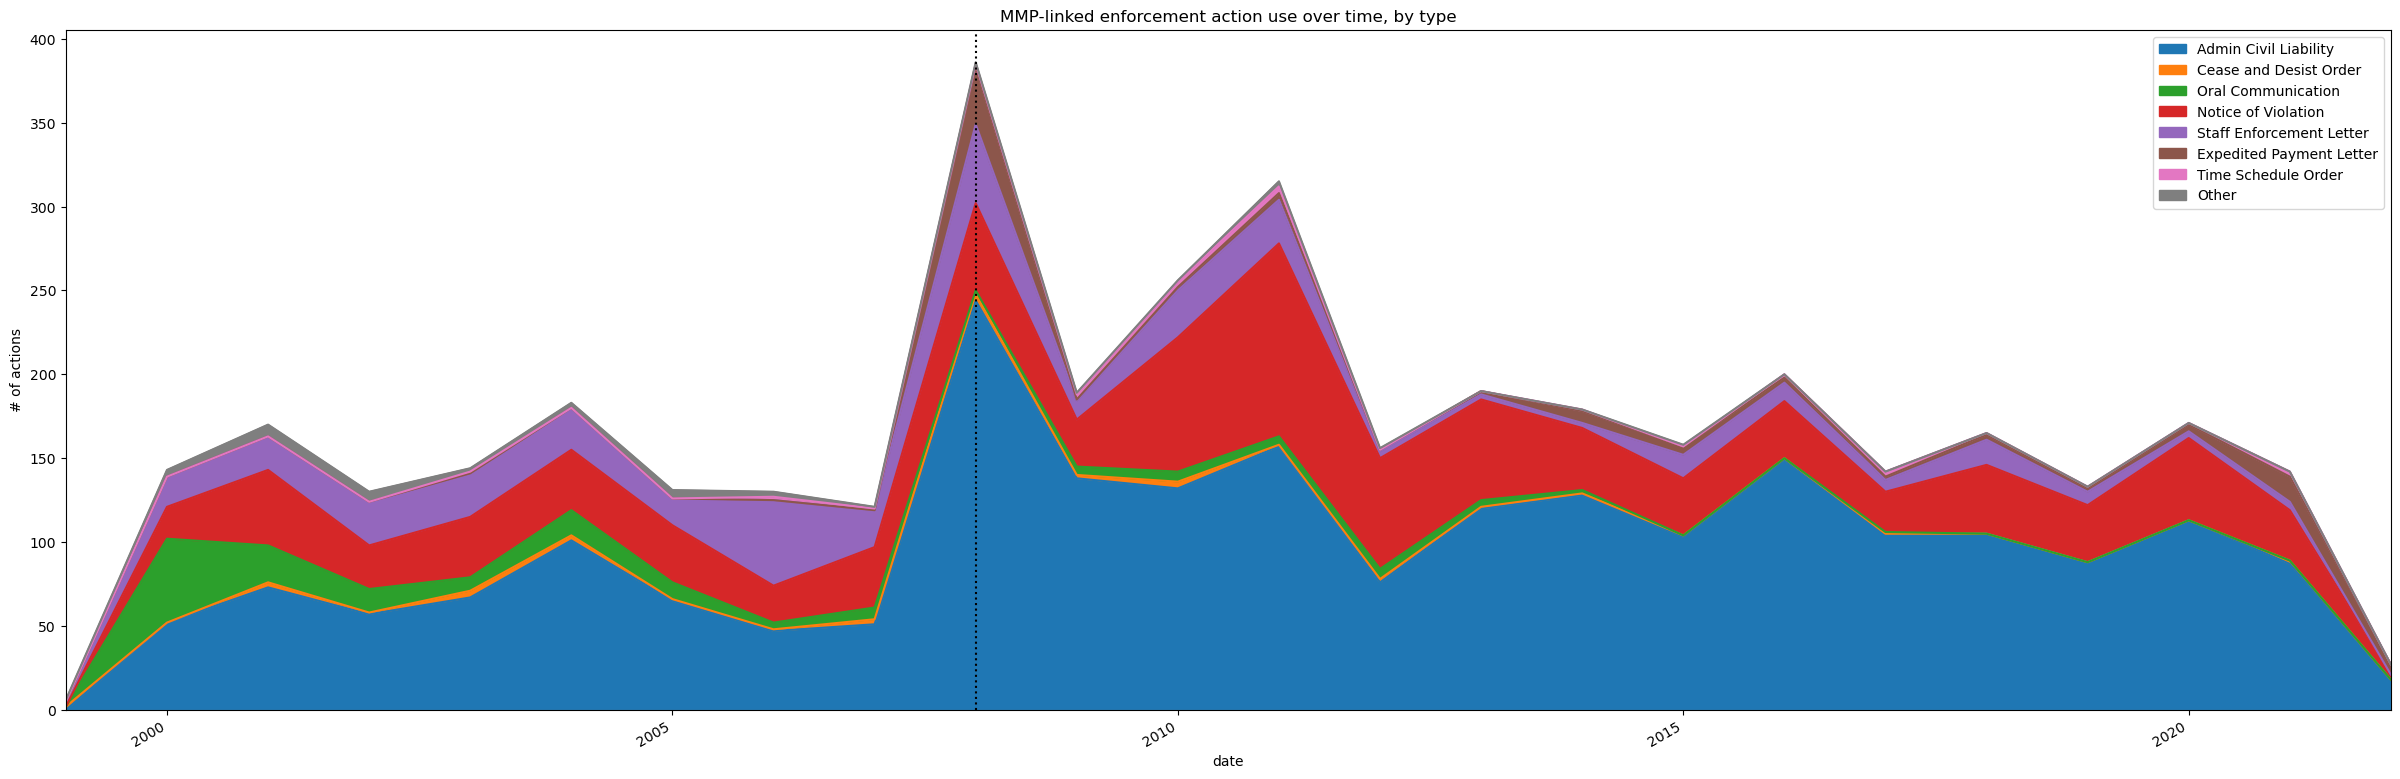

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcement_types_by_year_mmp[primary_actions_mmp + ['Other']].plot.area(ax=ax)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('MMP-linked enforcement action use over time, by type')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([1999, 2022]);

What if we break it down by region, instead of enforcement action type?

In [37]:
enforcements_by_region_by_year_mmp = enforcements_mmp.groupby(['effective_year', 'REGION']).size().to_frame('count')
enforcements_by_region_by_year_mmp.head()

count
effective_year REGION       
1997.0         5S          1
1999.0         1           3
               3           1
               5S          2
2000.0         1           5

In [38]:
enforcements_by_region_by_year_mmp = enforcements_by_region_by_year_mmp.pivot_table('count', index='effective_year', columns='REGION', fill_value=0)
enforcements_by_region_by_year_mmp.head()

REGION,1,2,3,4,5F,5R,5S,6A,6B,7,8,9
effective_year,,,,,,,,,,,,
1997.0,0,0,0,0,0,0,1,0,0,0,0,0
1999.0,3,0,1,0,0,0,2,0,0,0,0,0
2000.0,5,40,10,11,3,13,22,0,0,15,7,17
2001.0,11,27,13,46,4,6,22,0,0,28,8,5
2002.0,9,19,4,35,0,6,15,0,0,28,4,10


In [39]:
enforcements_by_region_by_year_mmp = pd.merge(enforcements_by_region_by_year_mmp, enforcement_years_mmp, how='right', on='effective_year').fillna(0).set_index('effective_year')
enforcements_by_region_by_year_mmp.head()

,1,2,3,4,5F,5R,5S,6A,6B,7,8,9
effective_year,,,,,,,,,,,,
1997.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2000.0,5.0,40.0,10.0,11.0,3.0,13.0,22.0,0.0,0.0,15.0,7.0,17.0
2001.0,11.0,27.0,13.0,46.0,4.0,6.0,22.0,0.0,0.0,28.0,8.0,5.0


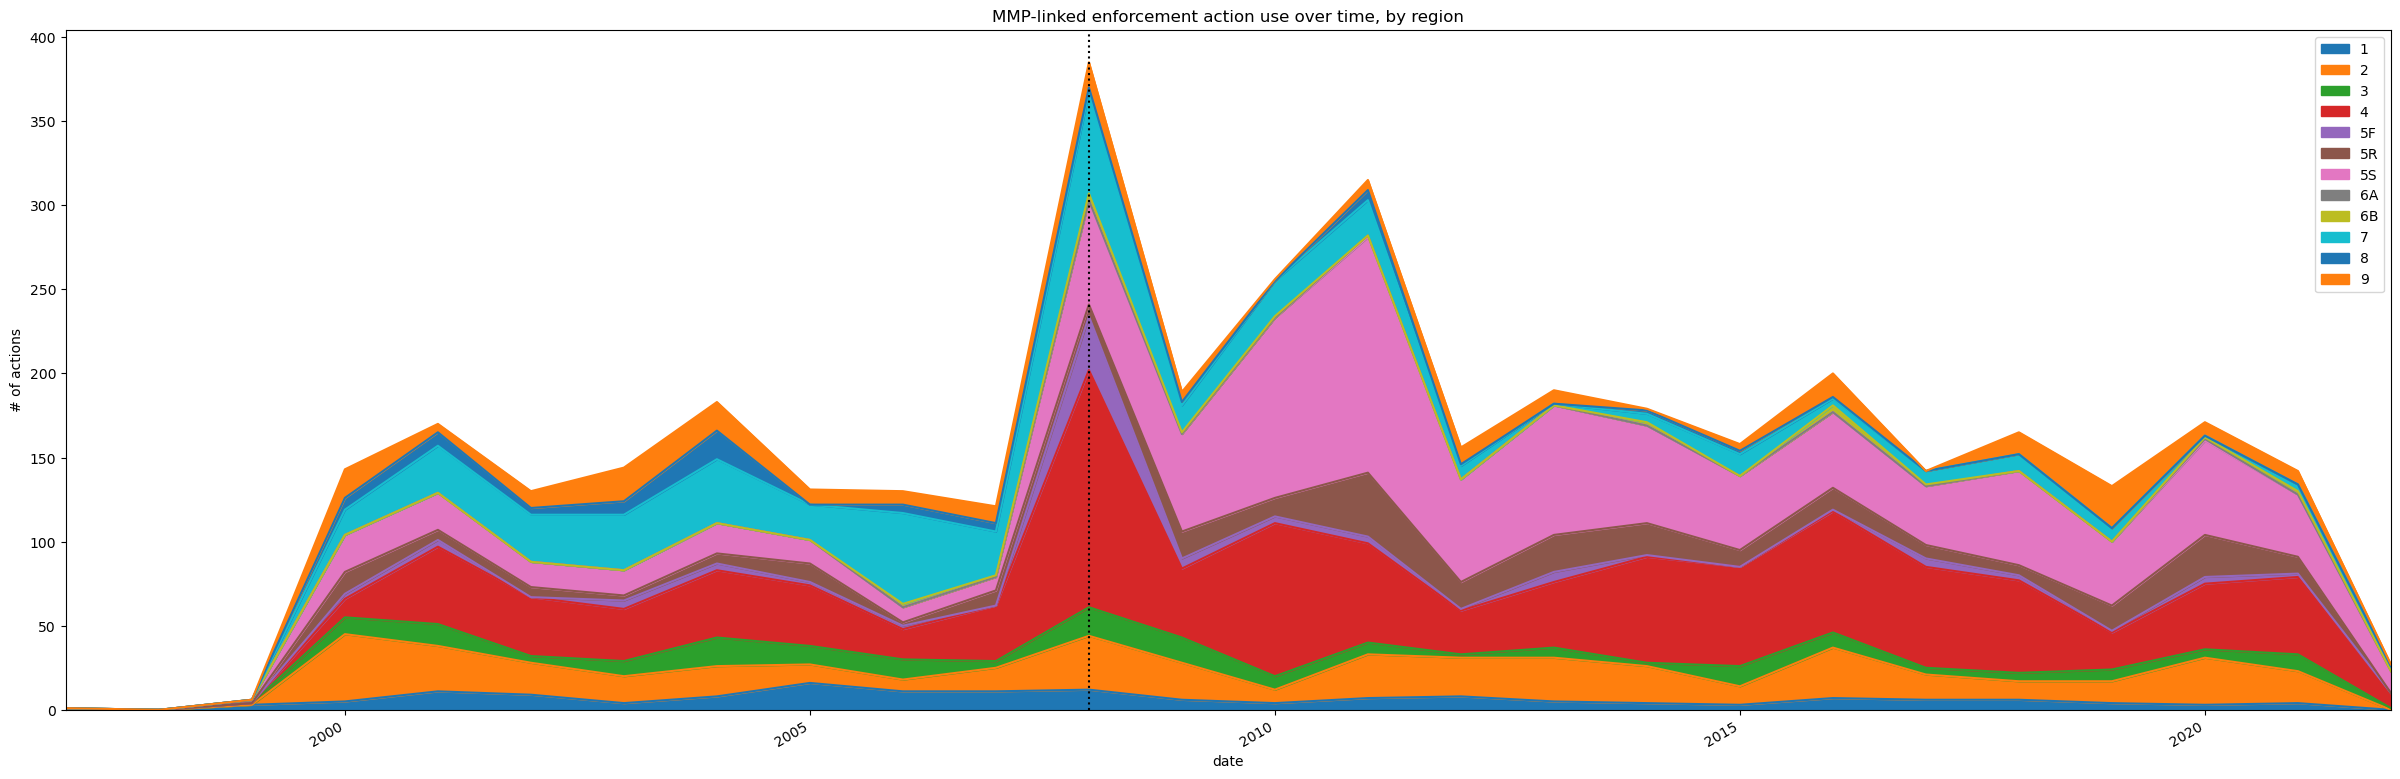

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcements_by_region_by_year_mmp.plot.area(ax=ax)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('MMP-linked enforcement action use over time, by region')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([1997, 2022]);

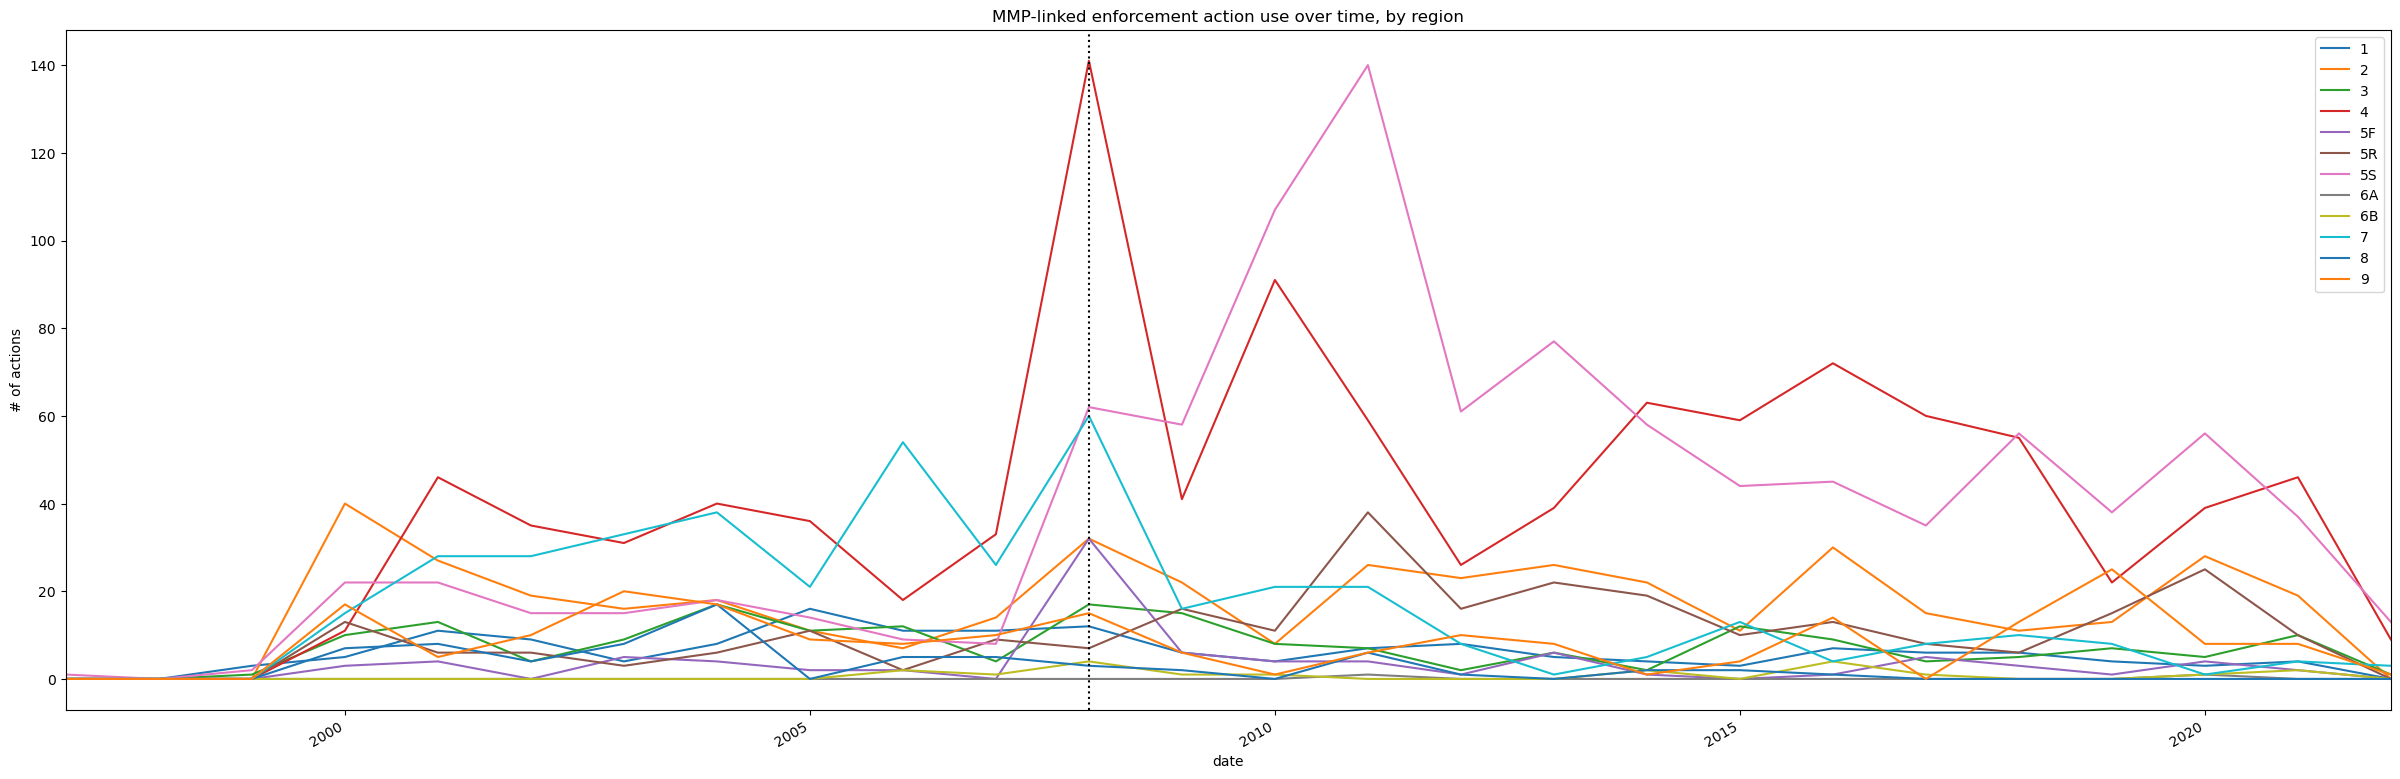

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcements_by_region_by_year_mmp.plot(ax=ax)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('MMP-linked enforcement action use over time, by region')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([1997, 2022]);

What about when we look just at valid, MMP-related EPLs and EPL-like ACLs?

In [42]:
enforcements_epl = main.get_epls(enforcements, issuance_dates_only=False, valid_only=True)
#enforcements_epl.head()

In [43]:
enforcements_epl['effective_year'] = enforcements_epl['EFFECTIVE DATE.1'].apply(lambda x: x.year)
enforcements_by_region_by_year_epl = enforcements_epl.groupby(['effective_year', 'REGION']).size().to_frame('count')
enforcements_by_region_by_year_epl.head()

count
effective_year REGION       
2002.0         2           1
2008.0         1           3
               2          31
               3           7
               4          89

In [44]:
enforcements_by_region_by_year_epl = enforcements_by_region_by_year_epl.pivot_table('count', index='effective_year', columns='REGION', fill_value=0)
enforcements_by_region_by_year_epl.head()

REGION,1,2,3,4,5F,5S,6A,6B,8,9
effective_year,,,,,,,,,,
2002.0,0,1,0,0,0,0,0,0,0,0
2008.0,3,31,7,89,0,0,0,0,0,0
2009.0,0,21,3,37,0,4,0,0,0,0
2010.0,0,1,0,17,0,0,0,0,0,0
2011.0,1,6,3,4,0,0,0,1,0,0


In [45]:
enforcement_years_epl = pd.DataFrame(range(int(np.min(enforcements_epl['effective_year'])), int(np.max(enforcements_epl['effective_year']))+1), columns=['effective_year'])

enforcements_by_region_by_year_epl = pd.merge(enforcements_by_region_by_year_epl, enforcement_years_epl, how='right', on='effective_year').fillna(0).set_index('effective_year')
enforcements_by_region_by_year_epl.head()

,1,2,3,4,5F,5S,6A,6B,8,9
effective_year,,,,,,,,,,
2002.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


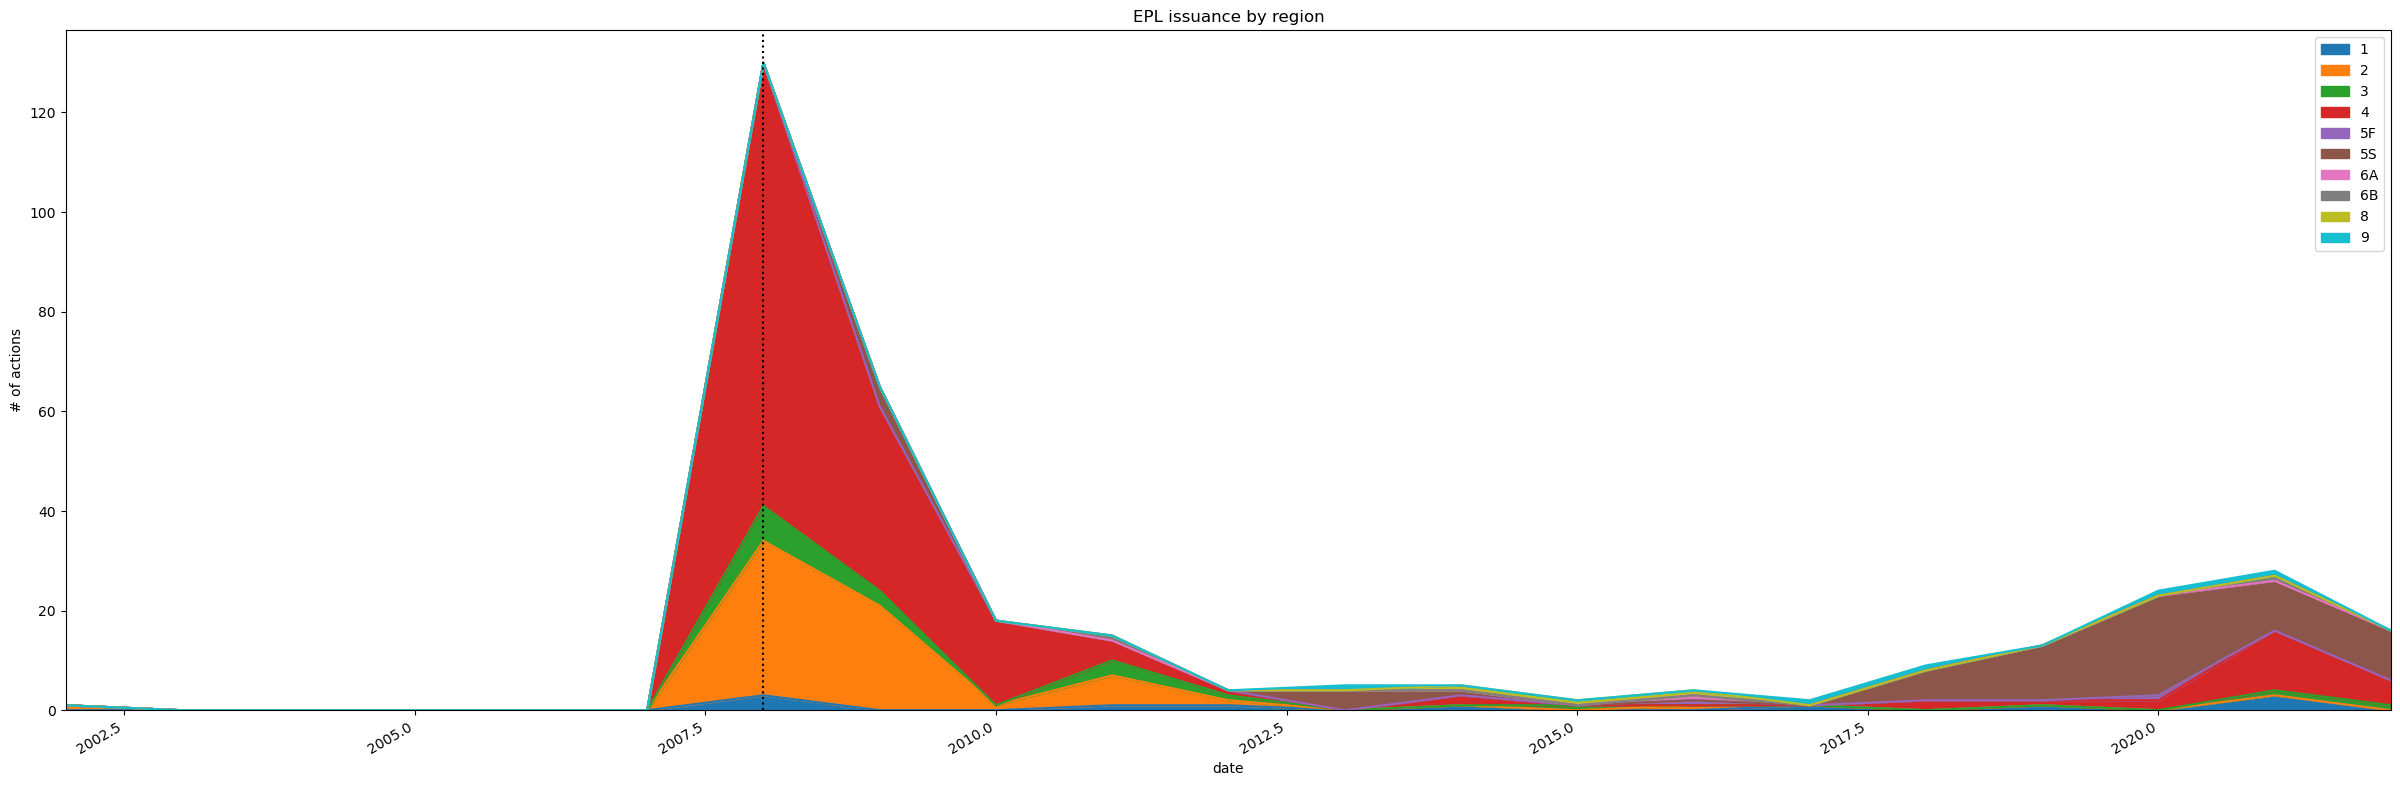

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcements_by_region_by_year_epl.plot.area(ax=ax)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('EPL issuance by region')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([2002, 2022]);

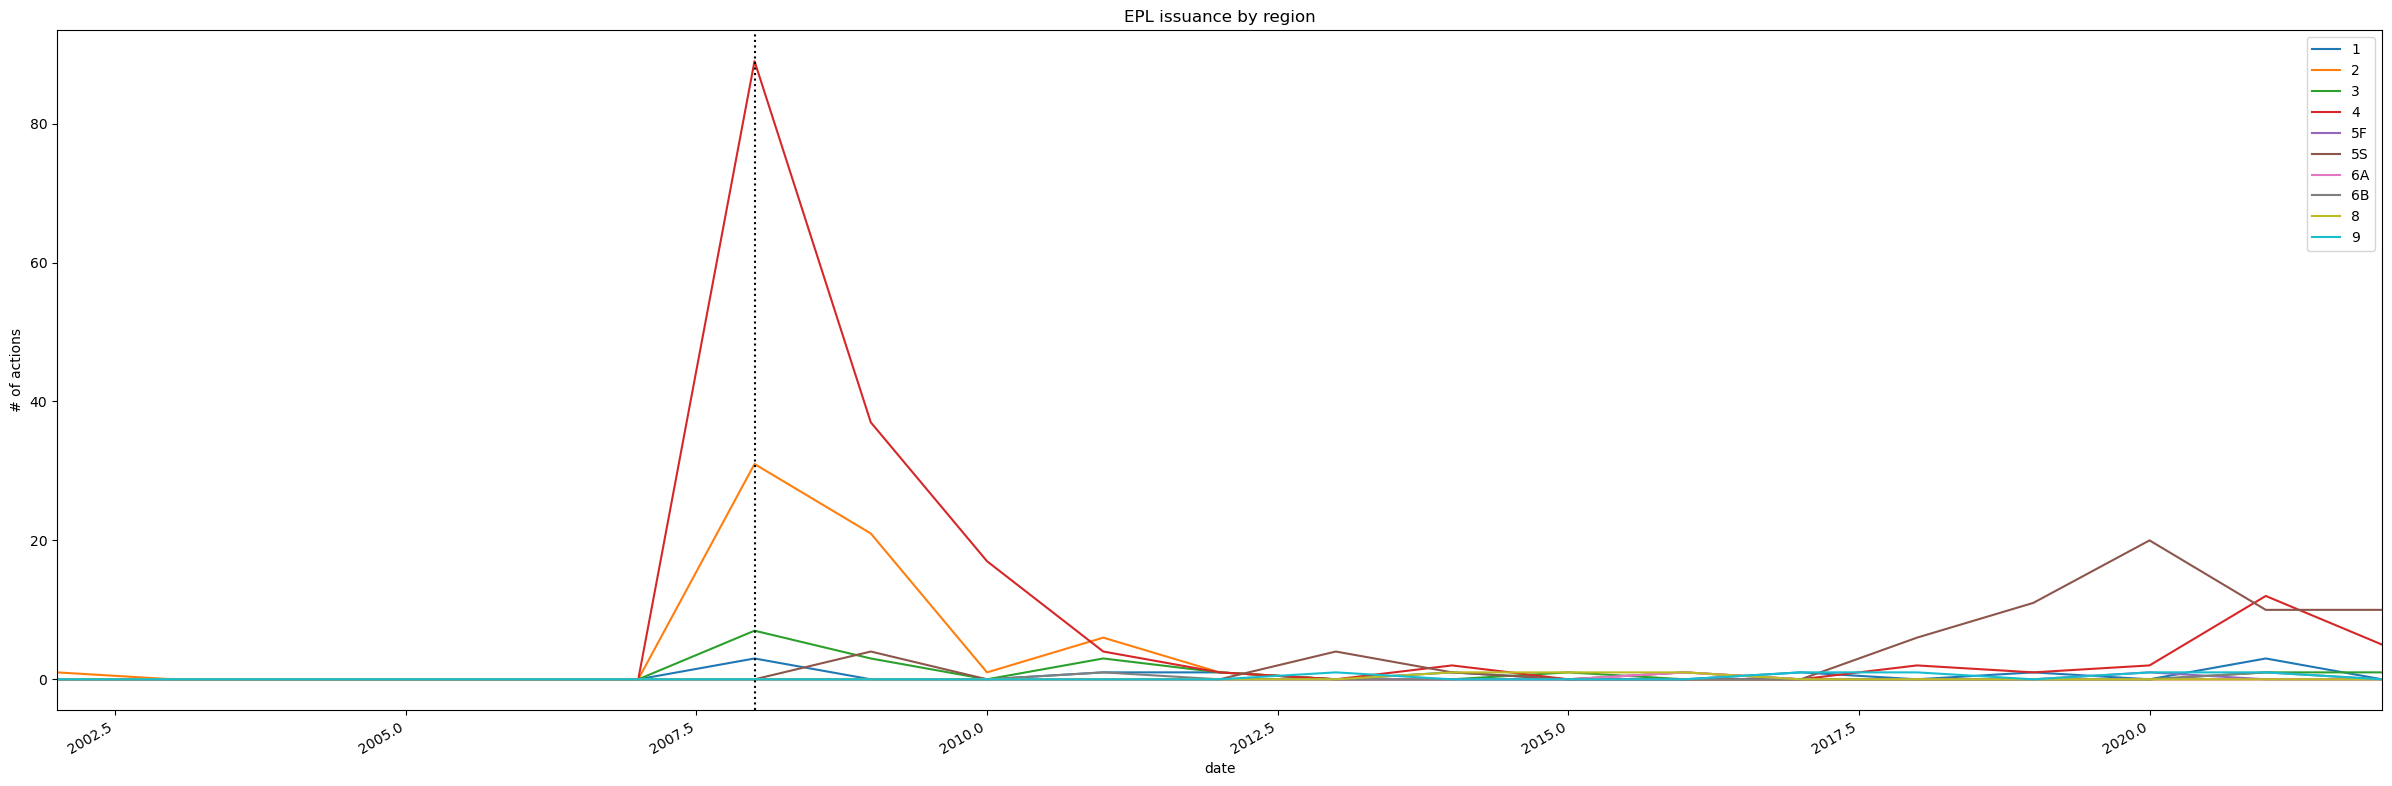

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
enforcements_by_region_by_year_epl.plot(ax=ax, rot=0)
ax.axvline(x=2008, linestyle=':', color='k')
fig.autofmt_xdate()
ax.set_title('EPL issuance by region')
ax.set_xlabel('date')
ax.set_ylabel('# of actions')
ax.set_xlim([2002, 2022]);

What's the average number of violations linked to each type of enforcement action?

In [48]:
enforcements_npdes.groupby(['ENFORCEMENT ACTION TYPE'])['TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION'].mean().sort_values(ascending=False)

ENFORCEMENT ACTION TYPE
Settlement - Court Order         150.785714
Formal Refer to Attorney Gen      90.636364
Referral to USEPA                 90.000000
Referral to Task Force            27.166667
Admin Civil Liability             16.443510
Cease and Desist Order            12.689602
Time Schedule Order               10.404130
Referral to Other Agency          10.333333
Notice of Violation               10.263878
Expedited Payment Letter           8.168385
13383 Letter                       6.500000
Staff Enforcement Letter           4.255780
Oral Communication                 3.309020
13267 Letter                       3.004651
Third Party Action                 2.500000
Notice to Comply                   1.717172
Waste Discharge Requirements       1.000000
Stipulated Penalty                 1.000000
Clean-up and Abatement Order       0.768939
Referral to District Attorney      0.000000
Name: TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION, dtype: float64

In [49]:
enforcements_mmp.groupby(['ENFORCEMENT ACTION TYPE'])['TOTAL MMP VIOLATIONS #'].mean().sort_values(ascending=False)

ENFORCEMENT ACTION TYPE
Referral to USEPA               573.000000
Formal Refer to Attorney Gen    483.000000
Settlement - Court Order        269.285714
Cease and Desist Order           23.789474
Referral to Other Agency         21.000000
Referral to Task Force           20.500000
Expedited Payment Letter         19.287129
Admin Civil Liability            16.933421
Notice of Violation              13.758475
Clean-up and Abatement Order     12.000000
13267 Letter                      5.500000
Staff Enforcement Letter          4.784119
Time Schedule Order               4.428571
Oral Communication                3.456790
Notice to Comply                  1.444444
Name: TOTAL MMP VIOLATIONS #, dtype: float64

##### 4. Looking at types of enforcements in our treatment and comparison groups.

In [50]:
# set aside enforcements for treatment and comparison groups
treatment_enforcements = enforcements_npdes[enforcements_npdes['FACILITY_ID'].apply(lambda x: x in treatment_facilities)]
comparison_enforcements = enforcements_npdes[enforcements_npdes['FACILITY_ID'].apply(lambda x: x in comparison_facilities)]

# MMP-only enforcements
treatment_enforcements_mmp = enforcements_mmp[enforcements_mmp['FACILITY_ID'].apply(lambda x: x in treatment_facilities)]
comparison_enforcements_mmp = enforcements_mmp[enforcements_mmp['FACILITY_ID'].apply(lambda x: x in comparison_facilities)]

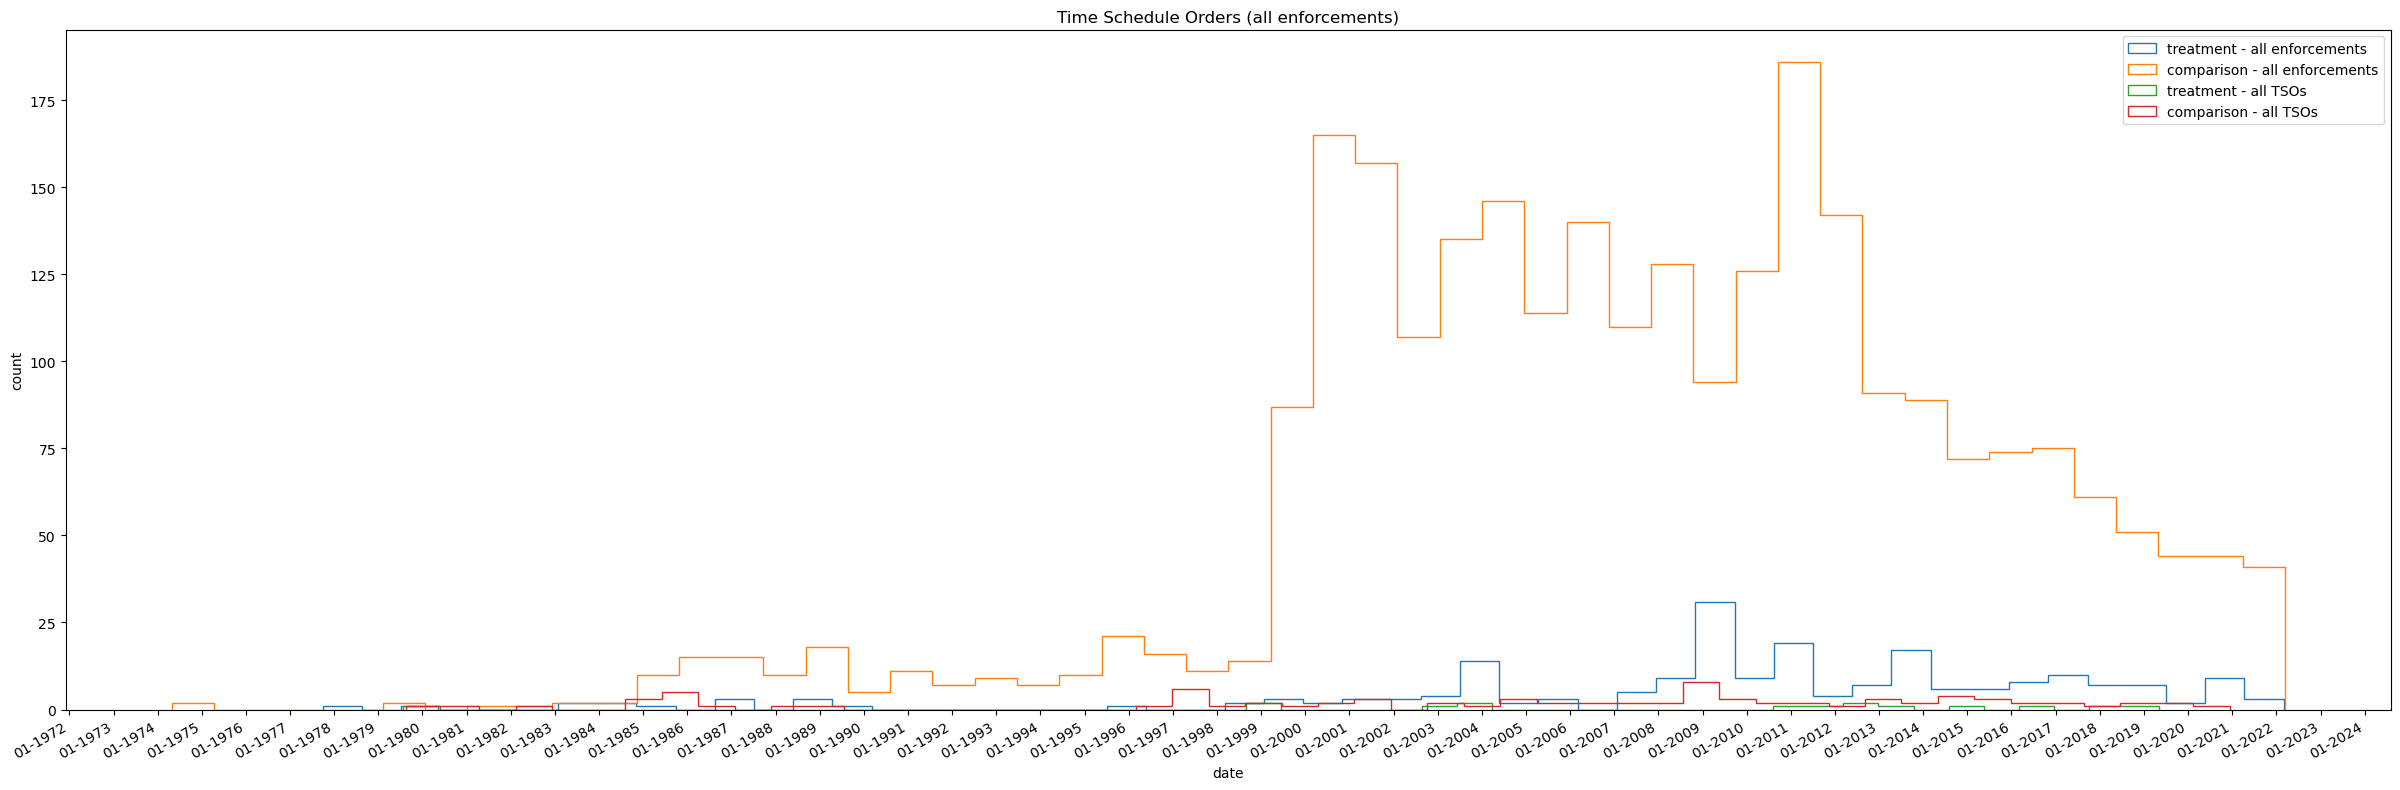

In [51]:
# plot Time Schedule Orders over time (all enforcements)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(treatment_enforcements['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(treatment_enforcements[treatment_enforcements['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements[comparison_enforcements['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['treatment - all enforcements', 'comparison - all enforcements','treatment - all TSOs', 'comparison - all TSOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('Time Schedule Orders (all enforcements)')
ax.set_xlabel('date')
ax.set_ylabel('count');

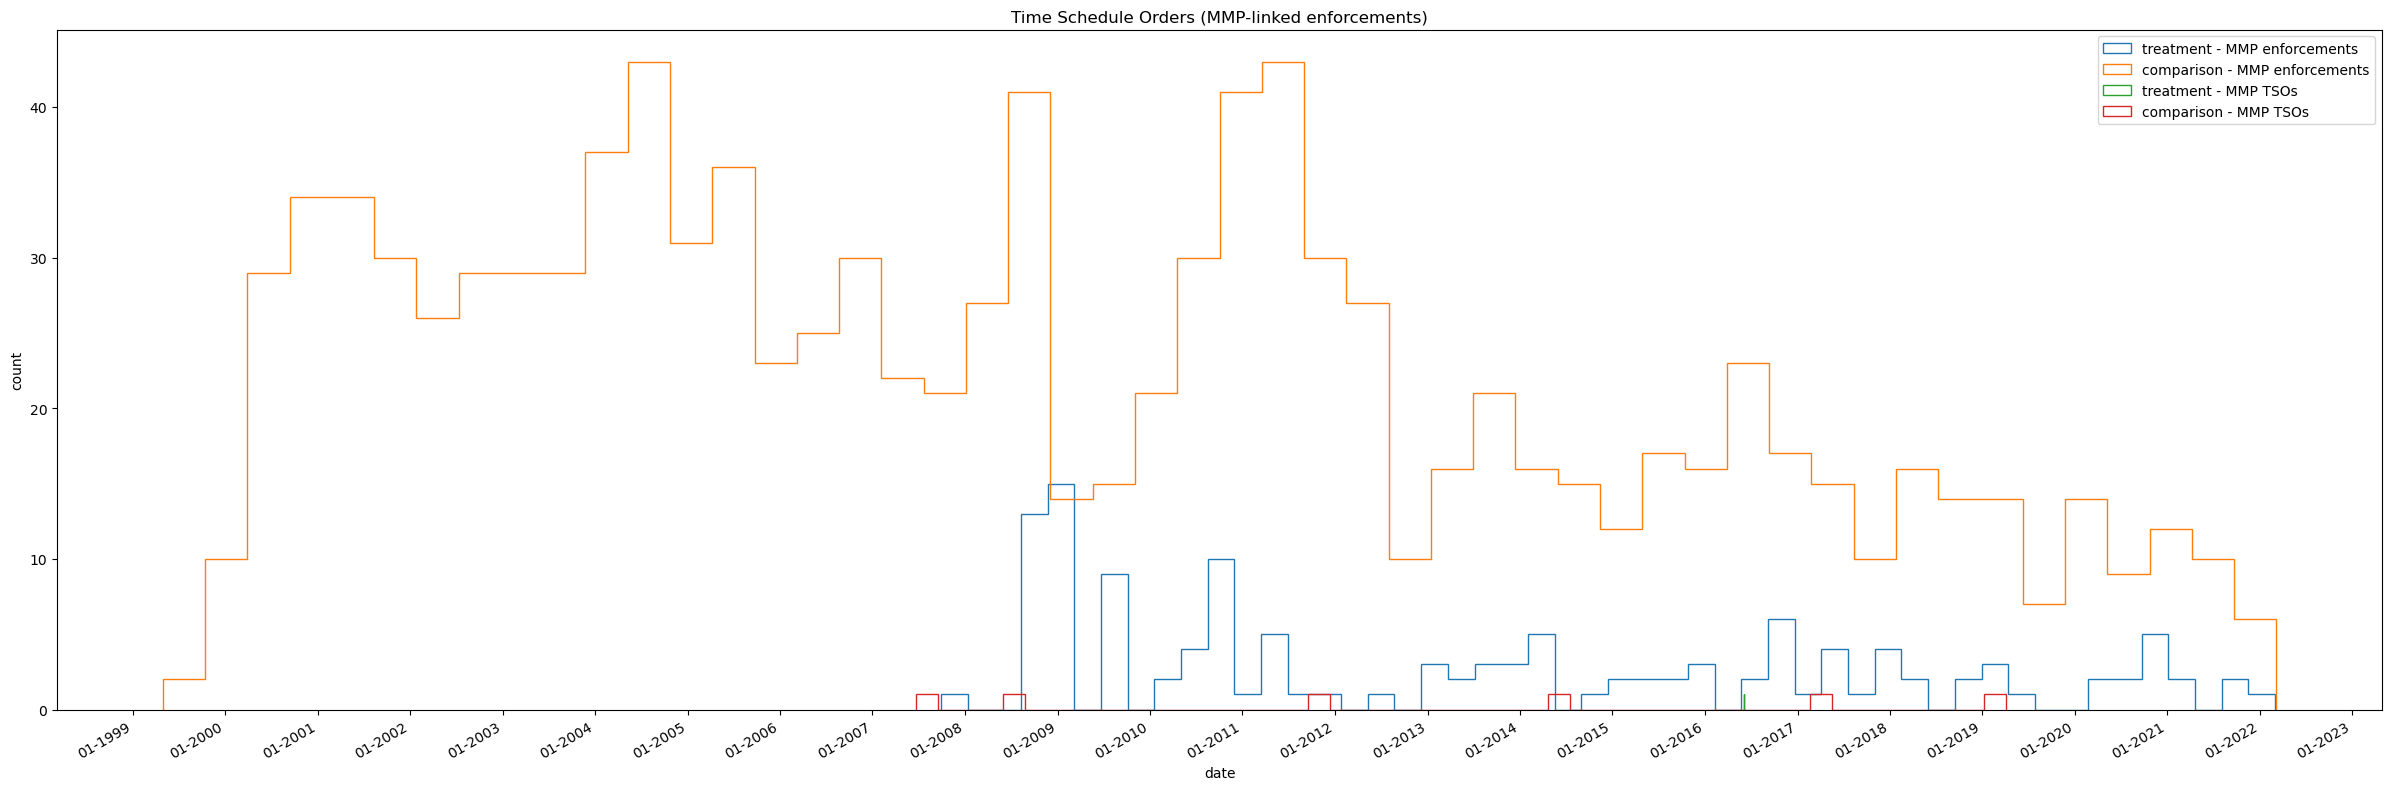

In [52]:
# plot Time Schedule Orders over time (MMP-related enforcements only)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(treatment_enforcements_mmp['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements_mmp['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(treatment_enforcements_mmp[treatment_enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements_mmp[comparison_enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Time Schedule Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['treatment - MMP enforcements', 'comparison - MMP enforcements','treatment - MMP TSOs', 'comparison - MMP TSOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('Time Schedule Orders (MMP-linked enforcements)')
ax.set_xlabel('date')
ax.set_ylabel('count');

In [53]:
print('Treatment facilities with ANY TSOs:')
print(treatment_enforcements[treatment_enforcements['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())
print('\nComparison facilities with ANY TSOs:')
print(comparison_enforcements[comparison_enforcements['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())

Treatment facilities with ANY TSOs:
['228856' '267571' '274044' '260494' '216832' '212135' '791884' '269042']

Comparison facilities with ANY TSOs:
['213432' '271490' '210322' '206730' '224137' '229725' '212739' '273182'
 '214642' '224901' '222407' '248586' '239343' '214933' '272291' '253953'
 '252771' '208630' '255265' '229726' '209551' '229967' '256056' '266919'
 '260429' '239874' '256217' '248796' '257592' '252657' '222057' '243420'
 '261253' '256919' '232297' '244348' '251217' '206164' '270419' '248886']


What if we subset to TSOs that were in effect during our analysis period?

In [54]:
treatment_enforcements_2004_2012 = treatment_enforcements[(treatment_enforcements['TERMINATION DATE.1'] >= pd.to_datetime('2004-01-01')) & (treatment_enforcements['EFFECTIVE DATE.1'] <= pd.to_datetime('2012-12-31'))]
comparison_enforcements_2004_2012 = comparison_enforcements[(comparison_enforcements['TERMINATION DATE.1'] >= pd.to_datetime('2004-01-01')) & (comparison_enforcements['EFFECTIVE DATE.1'] <= pd.to_datetime('2012-12-31'))]

In [55]:
print('Treatment facilities with ANY TSOs during 2004-2012:')
print(treatment_enforcements_2004_2012[treatment_enforcements_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())
print('\nComparison facilities with ANY TSOs during 2004-2012:')
print(comparison_enforcements_2004_2012[comparison_enforcements_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())

Treatment facilities with ANY TSOs during 2004-2012:
['267571' '274044' '216832' '212135' '260494']

Comparison facilities with ANY TSOs during 2004-2012:
['213432' '210322' '206730' '273182' '222407' '272291' '214642' '209551'
 '229967' '212739' '266919' '239874' '256217' '222057' '243420' '256919'
 '261253' '232297' '244348' '270419' '248886']


In [56]:
treatment_enforcements_mmp_2004_2012 = treatment_enforcements_mmp[(treatment_enforcements_mmp['TERMINATION DATE.1'] >= pd.to_datetime('2004-01-01')) & (treatment_enforcements_mmp['EFFECTIVE DATE.1'] <= pd.to_datetime('2012-12-31'))]
comparison_enforcements_mmp_2004_2012 = comparison_enforcements_mmp[(comparison_enforcements_mmp['TERMINATION DATE.1'] >= pd.to_datetime('2004-01-01')) & (comparison_enforcements_mmp['EFFECTIVE DATE.1'] <= pd.to_datetime('2012-12-31'))]

In [57]:
print('Treatment facilities with MMP-linked TSOs during 2004-2012:')
print(treatment_enforcements_mmp_2004_2012[treatment_enforcements_mmp_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())
print('\nComparison facilities with MMP-linked TSOs during 2004-2012:')
print(comparison_enforcements_mmp_2004_2012[comparison_enforcements_mmp_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order']['FACILITY_ID'].unique())

Treatment facilities with MMP-linked TSOs during 2004-2012:
[]

Comparison facilities with MMP-linked TSOs during 2004-2012:
['214642' '239874' '222057']


**MMP-linked TSOs during analysis period:**

Treatment group: 1 facility (1/46 = ~2.2%).

Comparison group: 3 facilities (3/96 = ~3.1%).

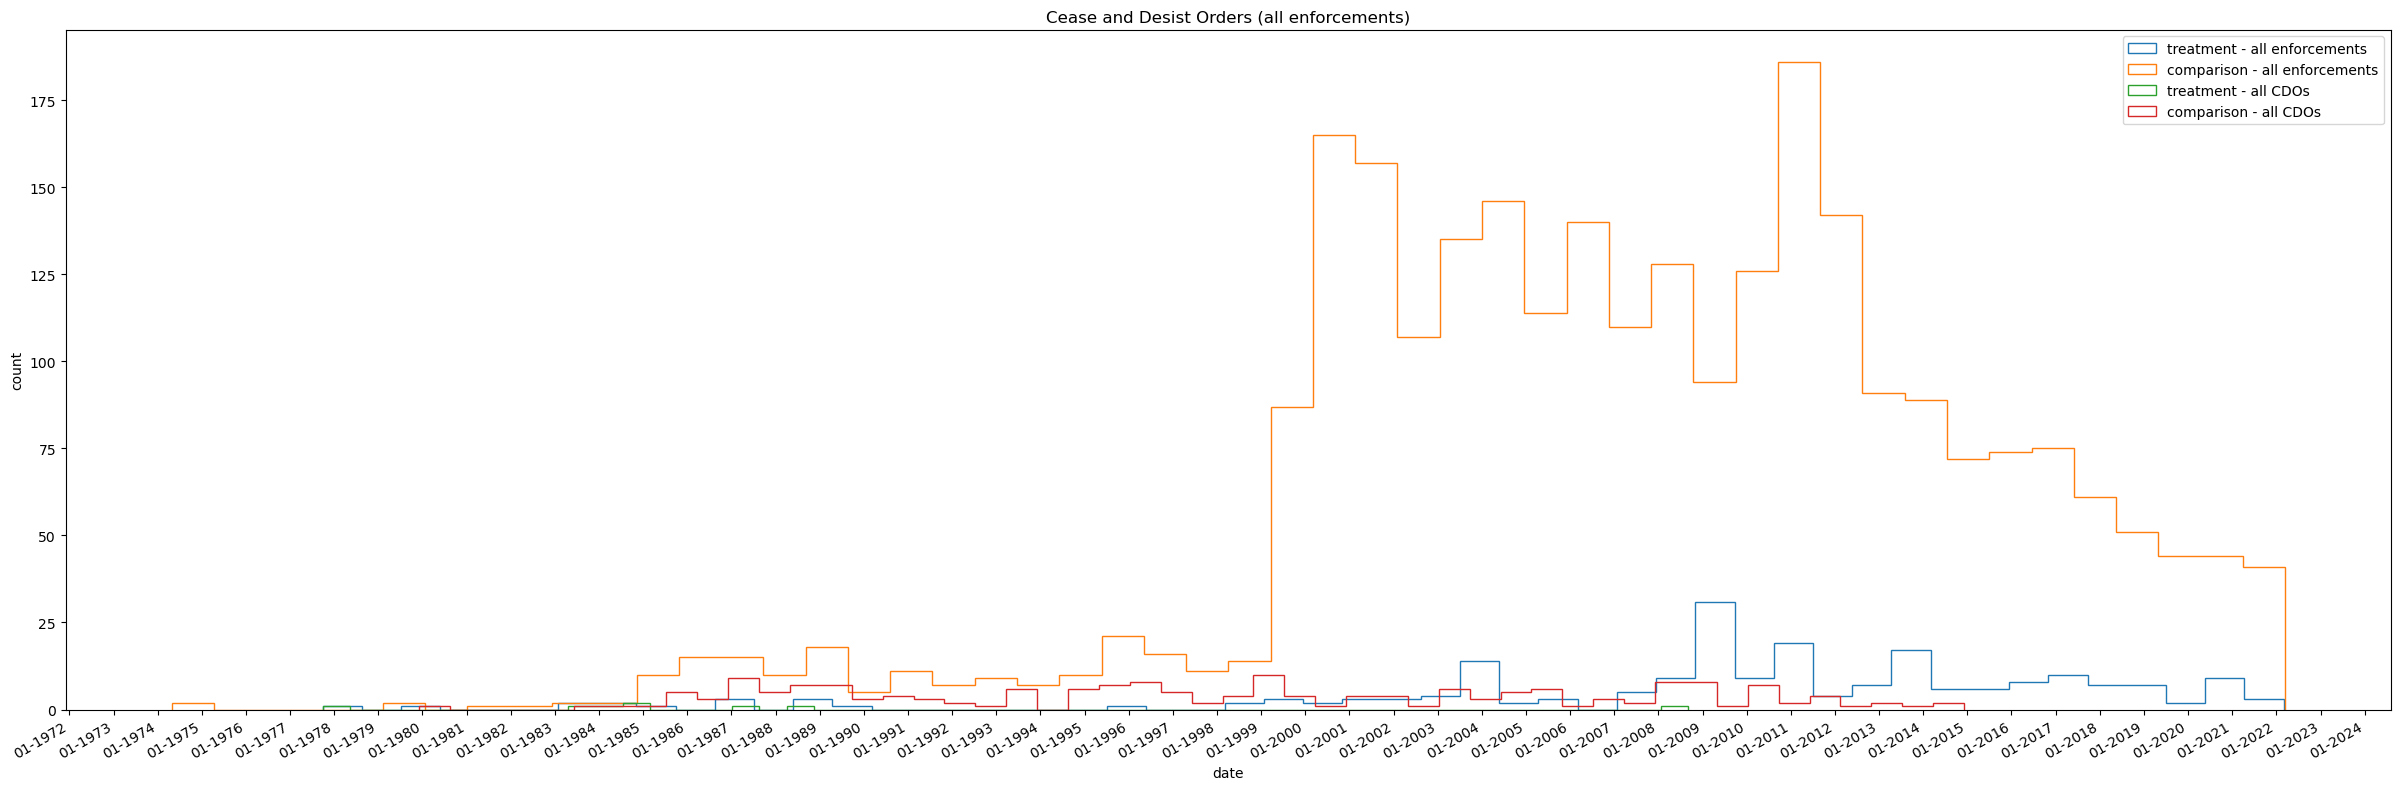

In [58]:
# plot Cease and Desist Orders over time (all enforcements)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(treatment_enforcements['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(treatment_enforcements[treatment_enforcements['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements[comparison_enforcements['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['treatment - all enforcements', 'comparison - all enforcements','treatment - all CDOs', 'comparison - all CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('Cease and Desist Orders (all enforcements)')
ax.set_xlabel('date')
ax.set_ylabel('count');

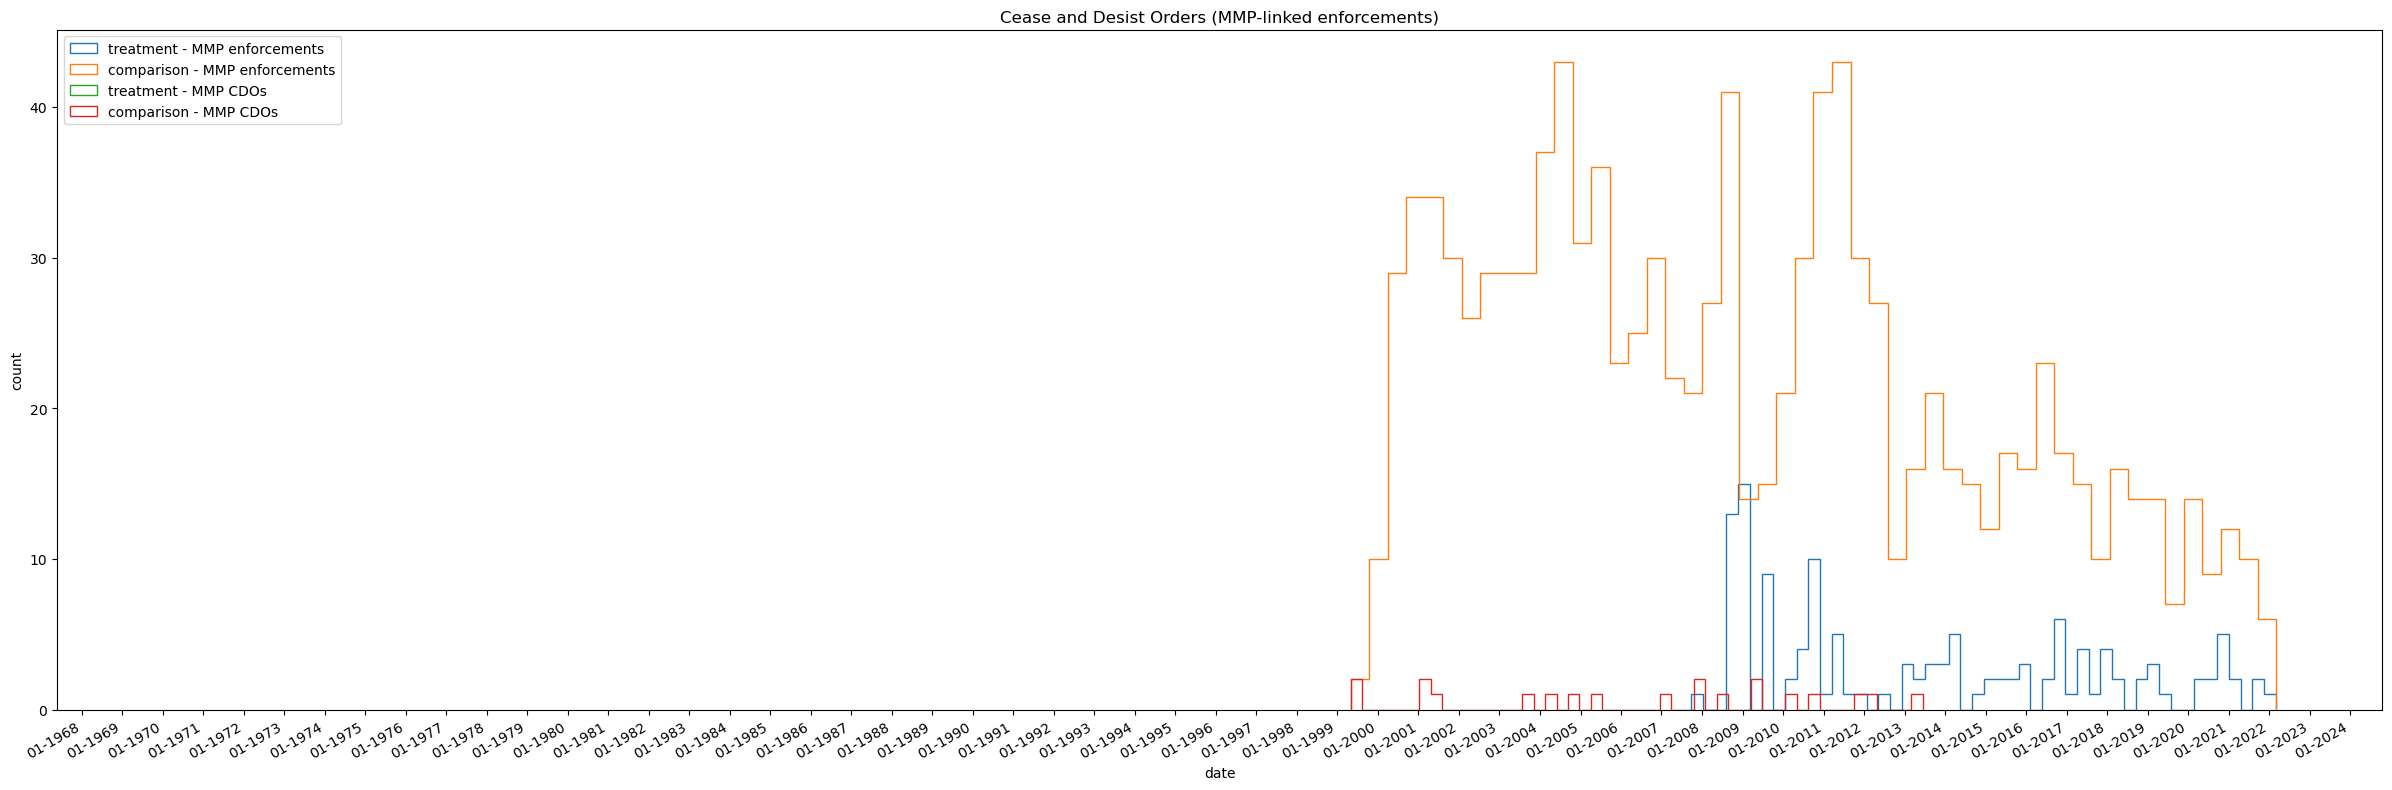

In [59]:
# plot Cease and Desist Orders over time (MMP-related enforcements only)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(treatment_enforcements_mmp['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements_mmp['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(treatment_enforcements_mmp[treatment_enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.hist(comparison_enforcements_mmp[comparison_enforcements_mmp['ENFORCEMENT ACTION TYPE']=='Cease and Desist Order']['EFFECTIVE DATE.1'], bins=50, histtype='step')
ax.legend(['treatment - MMP enforcements', 'comparison - MMP enforcements','treatment - MMP CDOs', 'comparison - MMP CDOs'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('Cease and Desist Orders (MMP-linked enforcements)')
ax.set_xlabel('date')
ax.set_ylabel('count');

In [60]:
print('Treatment facilities with ANY CDOs:')
print(treatment_enforcements[treatment_enforcements['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())
print('\nComparison facilities with ANY CDOs:')
print(comparison_enforcements[comparison_enforcements['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())

Treatment facilities with ANY CDOs:
['269042' '260494' '239497' '212135']

Comparison facilities with ANY CDOs:
['225055' '224348' '244705' '213432' '273180' '214933' '266439' '227818'
 '210322' '219701' '220548' '215106' '224901' '232297' '212585' '248586'
 '259165' '220315' '239874' '214647' '259149' '259171' '272291' '252211'
 '222407' '234156' '245949' '222057' '259161' '255265' '229726' '252119'
 '255333' '239343' '256217' '256056' '206164' '260429' '209551' '271805'
 '248796' '255337' '261253' '244348' '208276' '206730' '216106' '251217'
 '255420' '270419' '213577' '248886' '247457' '266694']


What if we subset to CDOs that were in effect during our analysis period?

In [61]:
print('Treatment facilities with ANY CDOs during 2004-2012:')
print(treatment_enforcements_2004_2012[treatment_enforcements_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())
print('\nComparison facilities with ANY CDOs during 2004-2012:')
print(comparison_enforcements_2004_2012[comparison_enforcements_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())

Treatment facilities with ANY CDOs during 2004-2012:
['239497']

Comparison facilities with ANY CDOs during 2004-2012:
['225055' '244705' '213432' '273180' '266439' '227818' '210322' '219701'
 '220548' '224901' '232297' '248586' '220315' '239874' '214647' '245949'
 '222057' '239343' '256217' '260429' '209551' '255337' '215106' '244348'
 '206730' '251217' '252119' '255420' '270419' '248886' '216106' '224348'
 '266694']


In [62]:
print('Treatment facilities with MMP-linked CDOs during 2004-2012:')
print(treatment_enforcements_mmp_2004_2012[treatment_enforcements_mmp_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())
print('\nComparison facilities with MMP-linked CDOs during 2004-2012:')
print(comparison_enforcements_mmp_2004_2012[comparison_enforcements_mmp_2004_2012['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order']['FACILITY_ID'].unique())

Treatment facilities with MMP-linked CDOs during 2004-2012:
[]

Comparison facilities with MMP-linked CDOs during 2004-2012:
['213432' '273180' '227818' '210322' '220548' '248586' '214647' '239343'
 '256217' '255337' '215106' '266694']


**MMP-linked CDOs during analysis period:**

Treatment group: 0 facilities (0/46 = 0%).

Comparison group: 12 facilities (12/96 = 12.5%).

**What types of enforcement actions are used to address MMP violations?**

First, let's look at the facility level.

In [63]:
print('Proportions of MMP violations addressed by each enforcement action type (facility-level):')

# total number of MMP violations per facility
enforcements_mmp_violcount = enforcements_mmp.groupby('FACILITY_ID', as_index=False).agg({'TOTAL MMP VIOLATIONS #': 'sum'})
enforcements_mmp_violcount.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcement_mmp_violcount_total'}, inplace=True)

enforcements_mmp_bytype = enforcements_mmp.groupby(['FACILITY_ID', 'ENFORCEMENT ACTION TYPE'], as_index=False).agg({'TOTAL MMP VIOLATIONS #': 'sum'})
enforcements_mmp_bytype.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcement_mmp_violcount_bytype'}, inplace=True)
enforcements_mmp_bytype = pd.merge(enforcements_mmp_bytype, enforcements_mmp_violcount, how = 'left', on = 'FACILITY_ID')
enforcements_mmp_bytype['enforcement_type_proportion'] = enforcements_mmp_bytype['enforcement_mmp_violcount_bytype'] / enforcements_mmp_bytype['enforcement_mmp_violcount_total']
enforcements_mmp_bytype[['FACILITY_ID', 'ENFORCEMENT ACTION TYPE', 'enforcement_type_proportion']].head(10)

Proportions of MMP violations addressed by each enforcement action type (facility-level):


,FACILITY_ID,ENFORCEMENT ACTION TYPE,enforcement_type_proportion
0,201056,Admin Civil Liability,1.000000
1,201397,Admin Civil Liability,1.000000
2,201399,Admin Civil Liability,1.000000
3,201440,Admin Civil Liability,1.000000
4,201552,Admin Civil Liability,1.000000
5,201664,Admin Civil Liability,0.600000
6,201664,Oral Communication,0.400000
7,201789,Admin Civil Liability,1.000000
8,201972,Admin Civil Liability,1.000000
9,202038,Admin Civil Liability,0.583333


In [64]:
print('Treatment facilities with TSOs or CDOs:')
enforcements_mmp_bytype[(enforcements_mmp_bytype['FACILITY_ID'].isin(treatment_facilities)) &
                                  ((enforcements_mmp_bytype['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order') |
                                   (enforcements_mmp_bytype['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order'))].sort_values('FACILITY_ID')

Treatment facilities with TSOs or CDOs:


,FACILITY_ID,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_bytype,enforcement_mmp_violcount_total,enforcement_type_proportion
447,228856,Time Schedule Order,1.0,351.0,0.002849


In [65]:
print('Comparison facilities with TSOs or CDOs:')
enforcements_mmp_bytype[(enforcements_mmp_bytype['FACILITY_ID'].isin(comparison_facilities)) &
                                  ((enforcements_mmp_bytype['ENFORCEMENT ACTION TYPE'] == 'Time Schedule Order') |
                                   (enforcements_mmp_bytype['ENFORCEMENT ACTION TYPE'] == 'Cease and Desist Order'))].sort_values('FACILITY_ID')

Comparison facilities with TSOs or CDOs:


,FACILITY_ID,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_bytype,enforcement_mmp_violcount_total,enforcement_type_proportion
109,210322,Cease and Desist Order,1.0,200.0,0.005000
154,213432,Cease and Desist Order,1.0,615.0,0.001626
177,214642,Time Schedule Order,10.0,552.0,0.018116
179,214647,Cease and Desist Order,30.0,1064.0,0.028195
192,215106,Cease and Desist Order,10.0,371.0,0.026954
288,220315,Cease and Desist Order,69.0,293.0,0.235495
294,220548,Cease and Desist Order,1.0,104.0,0.009615
323,222057,Time Schedule Order,6.0,115.0,0.052174
377,224901,Cease and Desist Order,7.0,180.0,0.038889
380,225055,Cease and Desist Order,27.0,147.0,0.183673


Now, let's zoom out and look at MMP enforcement across all facilities.

In [66]:
enforcements_mmp_bytype = enforcements_mmp_bytype.groupby('ENFORCEMENT ACTION TYPE', as_index=False).agg({'enforcement_mmp_violcount_bytype': 'sum'})
enforcements_mmp_bytype.rename(columns={'enforcement_mmp_violcount_bytype': 'enforcement_mmp_violcount_total'}, inplace=True)
enforcements_mmp_bytype

,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_total
0,13267 Letter,44.0
1,Admin Civil Liability,38629.0
2,Cease and Desist Order,904.0
3,Clean-up and Abatement Order,24.0
4,Expedited Payment Letter,1948.0
5,Formal Refer to Attorney Gen,1932.0
6,Notice of Violation,12988.0
7,Notice to Comply,13.0
8,Oral Communication,560.0
9,Referral to Other Agency,21.0


In [67]:
enforcements_mmp_bytype['enforcement_type_proportion'] = enforcements_mmp_bytype['enforcement_mmp_violcount_total'] / np.sum(enforcements_mmp_bytype['enforcement_mmp_violcount_total'])
enforcements_mmp_bytype.sort_values(ascending=False, by='enforcement_type_proportion')

,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_total,enforcement_type_proportion
1,Admin Civil Liability,38629.0,0.608340
6,Notice of Violation,12988.0,0.204539
12,Settlement - Court Order,3770.0,0.059371
4,Expedited Payment Letter,1948.0,0.030678
5,Formal Refer to Attorney Gen,1932.0,0.030426
13,Staff Enforcement Letter,1928.0,0.030363
2,Cease and Desist Order,904.0,0.014236
11,Referral to USEPA,573.0,0.009024
8,Oral Communication,560.0,0.008819
14,Time Schedule Order,124.0,0.001953


For our treatment facilities, how are MMP violations addressed?

In [68]:
enforcements_mmp_bytype = enforcements_mmp[enforcements_mmp['FACILITY_ID'].isin(treatment_facilities)].groupby('ENFORCEMENT ACTION TYPE', as_index=False).agg({'TOTAL MMP VIOLATIONS #': 'sum'})
enforcements_mmp_bytype.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcement_mmp_violcount_total'}, inplace=True)
enforcements_mmp_bytype['enf_type_proportion'] = enforcements_mmp_bytype['enforcement_mmp_violcount_total'] / np.sum(enforcements_mmp_bytype['enforcement_mmp_violcount_total'])
enforcements_mmp_bytype.sort_values(ascending=False, by='enf_type_proportion')

,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_total,enf_type_proportion
0,Admin Civil Liability,1394.0,0.995004
1,Notice of Violation,3.0,0.002141
2,Staff Enforcement Letter,3.0,0.002141
3,Time Schedule Order,1.0,0.000714


For our comparison facilities, how are MMP violations addressed?

In [69]:
enforcements_mmp_bytype = enforcements_mmp[enforcements_mmp['FACILITY_ID'].isin(comparison_facilities)].groupby('ENFORCEMENT ACTION TYPE', as_index=False).agg({'TOTAL MMP VIOLATIONS #': 'sum'})
enforcements_mmp_bytype.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcement_mmp_violcount_total'}, inplace=True)
enforcements_mmp_bytype['enf_type_proportion'] = enforcements_mmp_bytype['enforcement_mmp_violcount_total'] / np.sum(enforcements_mmp_bytype['enforcement_mmp_violcount_total'])
enforcements_mmp_bytype.sort_values(ascending=False, by='enf_type_proportion')

,ENFORCEMENT ACTION TYPE,enforcement_mmp_violcount_total,enf_type_proportion
1,Admin Civil Liability,14334.0,0.636021
4,Notice of Violation,5882.0,0.260993
9,Staff Enforcement Letter,964.0,0.042774
2,Cease and Desist Order,714.0,0.031681
6,Oral Communication,386.0,0.017127
8,Settlement - Court Order,140.0,0.006212
3,Expedited Payment Letter,55.0,0.002440
10,Time Schedule Order,24.0,0.001065
0,13267 Letter,22.0,0.000976
7,Referral to Task Force,13.0,0.000577


In [70]:
treatment_enforcements[(treatment_enforcements['FACILITY_ID'].isin(treatment_facilities)) & (treatment_enforcements['ENFORCEMENT ACTION TYPE'] == 'Expedited Payment Letter')]

,REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,# OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,# OF PLACES,SOURCE OF FACILITY,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,# OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,REGION.1,ORDER #,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,# OF STAFF ASSIGNED,SUPERVISOR,# OF SUPERVISORS,DIRECTION/VOICE,ENFORCEMENT ID (EID),REGION.2,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE.1,ADOPTION / ISSUANCE DATE,ACHIEVE DATE,TERMINATION DATE.1,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS.1,TITLE,DESCRIPTION,PROGRAM.1,PROGRAM CATEGORY.1,# OF PROGRAMS.1,ASSIGNED STAFF,# OF ASSIGNED STAFF,SUPERVISOR.1,# OF SUPERVISORS.1,LATEST MILESTONE COMPLETION DATE,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,AGENCY ISSUING ENF,DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION,RANK 1 VIOLATIONS,RANK 2 VIOLATIONS,RANK 3 VIOLATIONS,UNCLASSIFIED VIOLATIONS,ATOX VIOLATIONS #,BMP VIOLATIONS #,BASIN PLAN PROHIBITION VIOLATIONS #,CAT1 VIOLATIONS #,CAT2 VIOLATIONS #,CTOX VIOLATIONS #,DEFICIENT MONITORING VIOLATIONS #,DEFICIENT REPORT VIOLATIONS #,ENFORCEMENT ACTION VIOLATIONS #,FEES VIOLATIONS #,GROUNDWATER VIOLATIONS #,HYDRO MODIFICATION VIOLATIONS #,LATE REPORT VIOLATIONS #,OEV VIOLATIONS #,OTHER CODES VIOLATIONS #,PERMIT CONDITION VIOLATIONS #,PRETREATMENT VIOLATIONS #,REPORTING FAILURE TO NOTIFY VIOLATIONS #,SSO VIOLATIONS #,SURFACE WATER VIOLATIONS #,SWPPP VIOLATIONS #,UNAUTHORIZED DISCHARGE VIOLATIONS #,PRIORITY VIOLATIONS,TOTAL MMP VIOLATIONS #,EFFLUENT MMP SERIOUS,CHRONIC MMP,REPORTING MMP SERIOUS,TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION,ECONOMIC BENEFIT,STAFF COST,MAXIMUM POTENTIAL LIABILITY,effective_year
1555,4,267428,"TFX Aviation, Inc. (Former Telair Site, Newbur...",TFX Aviation Inc.,Manufacturing,Manufacturing NEC,Industrial,Privately-Owned Business,1.0,3085 Old Conejo Road,Newbury Park,91320,Ventura,34.189286,-118.940674,3728.0,"Aircraft Parts and Auxiliary Equipment, NEC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Reg Meas,0.115,2.0,B,X - Facility is not a POTW,Contaminated ground water,NaN,NaN,NaN,NPDESWW,NPDESWW,1.0,4A562397002,310024.0,NPDES Permits,4,R4-2003-0095,CA0059609,Minor,OTH,N - No,NaN,N,1000.0,Historical,1/20/12,7/10/03,6/10/08,3/4/09,NaN,NaN,NaN,NaN,NaN,NaN,N,I,66 - NPDES Based on Flow,NaN,NaN,NaN,NaN,Passive,358877,4,R4-2008-0173-M,Expedited Payment Letter,2008-12-19,NaN,NaN,2009-01-19,NaN,12/19/08,Withdrawn,Expedited Payment Letter sent 12/19/08 for 6 e...,Expedited Payment Letter sent 12/19/08 for 6 e...,NPDESWW,NPDESWW,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,2008.0
2139,4,211482,Reverse Osmosis Water Treatment Plant,Beverly Hills City DPW,Utility,Water Treatment Plant,All other facilities,City Agency,1.0,345 Foothill Road,Beverly Hills,90210,Los Angeles,34.074085,-118.396094,4941.0,Water Supply,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Reg Meas,3.000,3.0,B,X - Facility is not a POTW,Miscellaneous,NaN,NaN,NaN,NPDNONMUNIPRCS,NPDESWW,1.0,4B196100114,193681.0,Enrollee - NPDES,4,R4-2013-0095,CAG994004,Minor,OTH,N 